[race] is an integer from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern).


In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
import numpy as np
import plotly.express as px
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications import EfficientNetB0,Xception
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from PIL import Image

In [3]:
folders = [
    "/kaggle/input/utkface-dataset/part1/part1",
    "/kaggle/input/utkface-dataset/part2/part2",
    "/kaggle/input/utkface-dataset/part3/part3"
]

data = []

for folder in folders:
    for fname in os.listdir(folder):
        if fname.endswith(".jpg"):
            parts = fname.split("_")
            if len(parts) >= 4:
                try:
                    age = int(parts[0])
                    gender = int(parts[1])
                    race = int(parts[2])
                    full_path = os.path.join(folder, fname)
                    data.append((fname, full_path, age, gender, race))
                except:
                    continue  # Skip if filename is corrupted

# Buat DataFrame
df = pd.DataFrame(data, columns=["filename", "filepath", "age", "gender", "race"])
print(f"Total images: {len(df)}")
df.head()

Total images: 24102


filename  \
0  10_0_0_20170110220548521.jpg   
1   2_1_4_20161221195444552.jpg   
2   1_1_2_20161219155356357.jpg   
3  49_0_0_20170103182824970.jpg   
4   1_1_0_20170109190459034.jpg   

                                            filepath  age  gender  race  
0  /kaggle/input/utkface-dataset/part1/part1/10_0...   10       0     0  
1  /kaggle/input/utkface-dataset/part1/part1/2_1_...    2       1     4  
2  /kaggle/input/utkface-dataset/part1/part1/1_1_...    1       1     2  
3  /kaggle/input/utkface-dataset/part1/part1/49_0...   49       0     0  
4  /kaggle/input/utkface-dataset/part1/part1/1_1_...    1       1     0

In [4]:
df["age"].describe()

count    24102.000000
mean        33.041781
std         20.138950
min          1.000000
25%         23.000000
50%         29.000000
75%         45.000000
max        116.000000
Name: age, dtype: float64

In [5]:
df["race"].value_counts()

race
0    10221
1     4558
3     4027
2     3586
4     1710
Name: count, dtype: int64

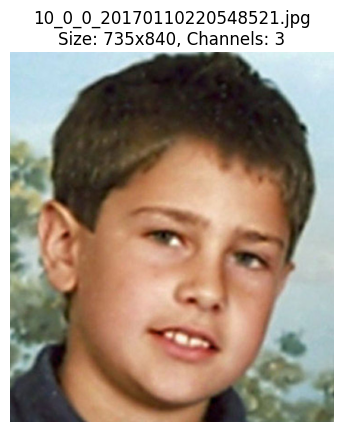

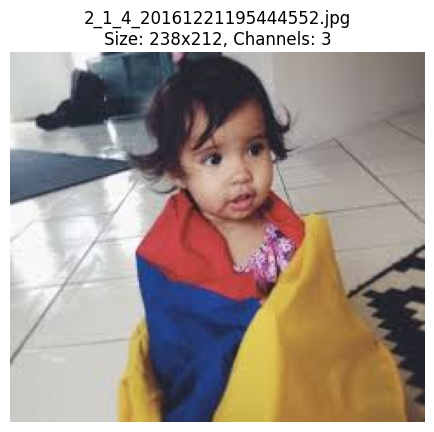

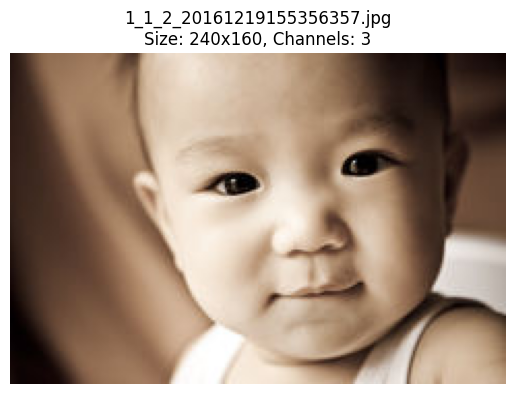

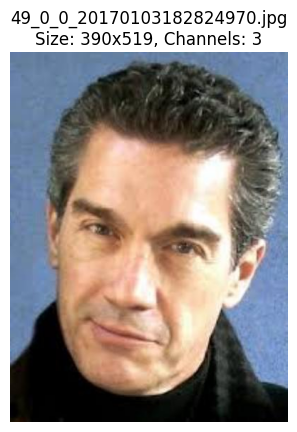

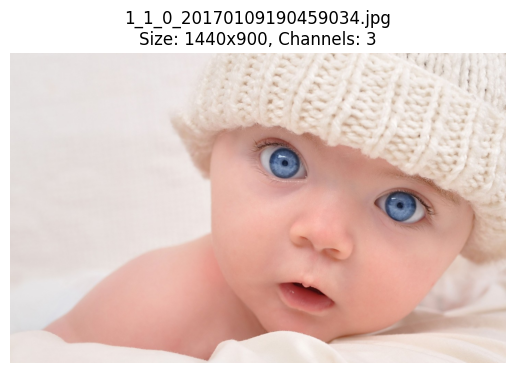

In [8]:
def show_images(df,n):
    for i in range(n):
        row = df.iloc[i]
        img = mpimg.imread(row['filepath'])
        h, w, c = img.shape
        plt.imshow(img)
        plt.title(f"{row['filename']}\nSize: {w}x{h}, Channels: {c}")
        plt.axis('off')
        plt.show()
        
show_images(df,5)

In [6]:
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df["race"], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["race"], random_state=42)

print(len(train_df))
print(len(val_df))
print(len(test_df))

19281
2410
2411


In [4]:
IMG_SIZE = 224

def preprocess(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

def make_dataset(df, label_col):
    paths = df["filepath"].values
    labels = df[label_col].values

    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
    return ds

2025-07-04 22:54:47.626695: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751669687.815140      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751669687.866899      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [12]:
train_ds = make_dataset(train_df, "race")
val_ds   = make_dataset(val_df, "race")
test_ds  = make_dataset(test_df, "race")

I0000 00:00:1751574351.942269      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


# Model 1 (1 output: race)

In [41]:
base = Xception(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), weights='imagenet')
base.trainable = False

model = models.Sequential([
    base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax') 
])
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 7, 7, 2048)          │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_5           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,419,565 (81.71 MB)

 Trainable params: 558,085 (2.13 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [42]:
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=3,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(train_ds, validation_data=val_ds, epochs=100, callbacks=[early_stop])

Epoch 1/100


Corrupt JPEG data: premature end of data segment


 43/603 ━━━━━━━━━━━━━━━━━━━━ 49s 89ms/step - accuracy: 0.2621 - loss: 1.6512

Corrupt JPEG data: premature end of data segment


603/603 ━━━━━━━━━━━━━━━━━━━━ 71s 100ms/step - accuracy: 0.4052 - loss: 1.4503 - val_accuracy: 0.5469 - val_loss: 1.2056
Epoch 2/100


Corrupt JPEG data: premature end of data segment


 43/603 ━━━━━━━━━━━━━━━━━━━━ 47s 86ms/step - accuracy: 0.4990 - loss: 1.2567

Corrupt JPEG data: premature end of data segment


603/603 ━━━━━━━━━━━━━━━━━━━━ 55s 87ms/step - accuracy: 0.5074 - loss: 1.2540 - val_accuracy: 0.5672 - val_loss: 1.1427
Epoch 3/100


Corrupt JPEG data: premature end of data segment


 43/603 ━━━━━━━━━━━━━━━━━━━━ 47s 85ms/step - accuracy: 0.5187 - loss: 1.2267

Corrupt JPEG data: premature end of data segment


603/603 ━━━━━━━━━━━━━━━━━━━━ 55s 87ms/step - accuracy: 0.5425 - loss: 1.2001 - val_accuracy: 0.5855 - val_loss: 1.1146
Epoch 4/100


Corrupt JPEG data: premature end of data segment


 43/603 ━━━━━━━━━━━━━━━━━━━━ 47s 84ms/step - accuracy: 0.5496 - loss: 1.2056

Corrupt JPEG data: premature end of data segment


603/603 ━━━━━━━━━━━━━━━━━━━━ 55s 87ms/step - accuracy: 0.5598 - loss: 1.1593 - val_accuracy: 0.6037 - val_loss: 1.0846
Epoch 5/100


Corrupt JPEG data: premature end of data segment


 43/603 ━━━━━━━━━━━━━━━━━━━━ 47s 85ms/step - accuracy: 0.5737 - loss: 1.1341

Corrupt JPEG data: premature end of data segment


603/603 ━━━━━━━━━━━━━━━━━━━━ 55s 87ms/step - accuracy: 0.5777 - loss: 1.1317 - val_accuracy: 0.5971 - val_loss: 1.0714
Epoch 6/100


Corrupt JPEG data: premature end of data segment


 43/603 ━━━━━━━━━━━━━━━━━━━━ 46s 84ms/step - accuracy: 0.5963 - loss: 1.0804

Corrupt JPEG data: premature end of data segment


603/603 ━━━━━━━━━━━━━━━━━━━━ 55s 87ms/step - accuracy: 0.5868 - loss: 1.0965 - val_accuracy: 0.6120 - val_loss: 1.0593
Epoch 7/100


Corrupt JPEG data: premature end of data segment


 43/603 ━━━━━━━━━━━━━━━━━━━━ 47s 85ms/step - accuracy: 0.5620 - loss: 1.1386

Corrupt JPEG data: premature end of data segment


603/603 ━━━━━━━━━━━━━━━━━━━━ 55s 87ms/step - accuracy: 0.5956 - loss: 1.0748 - val_accuracy: 0.6170 - val_loss: 1.0461
Epoch 8/100


Corrupt JPEG data: premature end of data segment


 43/603 ━━━━━━━━━━━━━━━━━━━━ 46s 83ms/step - accuracy: 0.6041 - loss: 1.0982

Corrupt JPEG data: premature end of data segment


603/603 ━━━━━━━━━━━━━━━━━━━━ 54s 87ms/step - accuracy: 0.6090 - loss: 1.0518 - val_accuracy: 0.6166 - val_loss: 1.0412
Epoch 9/100


Corrupt JPEG data: premature end of data segment


 43/603 ━━━━━━━━━━━━━━━━━━━━ 47s 84ms/step - accuracy: 0.5940 - loss: 1.0782

Corrupt JPEG data: premature end of data segment


603/603 ━━━━━━━━━━━━━━━━━━━━ 55s 88ms/step - accuracy: 0.6152 - loss: 1.0283 - val_accuracy: 0.6249 - val_loss: 1.0321
Epoch 10/100


Corrupt JPEG data: premature end of data segment


 43/603 ━━━━━━━━━━━━━━━━━━━━ 47s 84ms/step - accuracy: 0.6416 - loss: 1.0066

Corrupt JPEG data: premature end of data segment


603/603 ━━━━━━━━━━━━━━━━━━━━ 55s 87ms/step - accuracy: 0.6301 - loss: 1.0092 - val_accuracy: 0.6253 - val_loss: 1.0227
Epoch 11/100


Corrupt JPEG data: premature end of data segment


 43/603 ━━━━━━━━━━━━━━━━━━━━ 47s 85ms/step - accuracy: 0.6312 - loss: 0.9967

Corrupt JPEG data: premature end of data segment


603/603 ━━━━━━━━━━━━━━━━━━━━ 55s 87ms/step - accuracy: 0.6319 - loss: 0.9881 - val_accuracy: 0.6253 - val_loss: 1.0224
Epoch 12/100


Corrupt JPEG data: premature end of data segment


 43/603 ━━━━━━━━━━━━━━━━━━━━ 49s 89ms/step - accuracy: 0.6446 - loss: 0.9888

Corrupt JPEG data: premature end of data segment


603/603 ━━━━━━━━━━━━━━━━━━━━ 55s 87ms/step - accuracy: 0.6403 - loss: 0.9698 - val_accuracy: 0.6336 - val_loss: 1.0138
Epoch 13/100


Corrupt JPEG data: premature end of data segment


 43/603 ━━━━━━━━━━━━━━━━━━━━ 46s 83ms/step - accuracy: 0.6657 - loss: 0.9374

Corrupt JPEG data: premature end of data segment


603/603 ━━━━━━━━━━━━━━━━━━━━ 54s 87ms/step - accuracy: 0.6508 - loss: 0.9487 - val_accuracy: 0.6378 - val_loss: 1.0163
Epoch 14/100


Corrupt JPEG data: premature end of data segment


 43/603 ━━━━━━━━━━━━━━━━━━━━ 47s 84ms/step - accuracy: 0.6515 - loss: 0.9836

Corrupt JPEG data: premature end of data segment


603/603 ━━━━━━━━━━━━━━━━━━━━ 54s 87ms/step - accuracy: 0.6567 - loss: 0.9358 - val_accuracy: 0.6357 - val_loss: 1.0084
Epoch 15/100


Corrupt JPEG data: premature end of data segment


 43/603 ━━━━━━━━━━━━━━━━━━━━ 46s 83ms/step - accuracy: 0.6446 - loss: 0.9298

Corrupt JPEG data: premature end of data segment


603/603 ━━━━━━━━━━━━━━━━━━━━ 54s 87ms/step - accuracy: 0.6611 - loss: 0.9148 - val_accuracy: 0.6461 - val_loss: 1.0062
Epoch 16/100


Corrupt JPEG data: premature end of data segment


 43/603 ━━━━━━━━━━━━━━━━━━━━ 47s 84ms/step - accuracy: 0.6674 - loss: 0.9230

Corrupt JPEG data: premature end of data segment


603/603 ━━━━━━━━━━━━━━━━━━━━ 54s 87ms/step - accuracy: 0.6688 - loss: 0.8973 - val_accuracy: 0.6436 - val_loss: 1.0074
Epoch 17/100


Corrupt JPEG data: premature end of data segment


 42/603 ━━━━━━━━━━━━━━━━━━━━ 46s 83ms/step - accuracy: 0.6646 - loss: 0.9224

Corrupt JPEG data: premature end of data segment


603/603 ━━━━━━━━━━━━━━━━━━━━ 54s 86ms/step - accuracy: 0.6795 - loss: 0.8747 - val_accuracy: 0.6411 - val_loss: 1.0082
Epoch 18/100


Corrupt JPEG data: premature end of data segment


 43/603 ━━━━━━━━━━━━━━━━━━━━ 46s 84ms/step - accuracy: 0.6757 - loss: 0.8976

Corrupt JPEG data: premature end of data segment


603/603 ━━━━━━━━━━━━━━━━━━━━ 54s 87ms/step - accuracy: 0.6841 - loss: 0.8611 - val_accuracy: 0.6402 - val_loss: 1.0080
Epoch 18: early stopping
Restoring model weights from the end of the best epoch: 15.


In [43]:
 model.evaluate(test_ds)

76/76 ━━━━━━━━━━━━━━━━━━━━ 9s 91ms/step - accuracy: 0.6149 - loss: 1.0281


[1.017151117324829, 0.6233927607536316]

76/76 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step


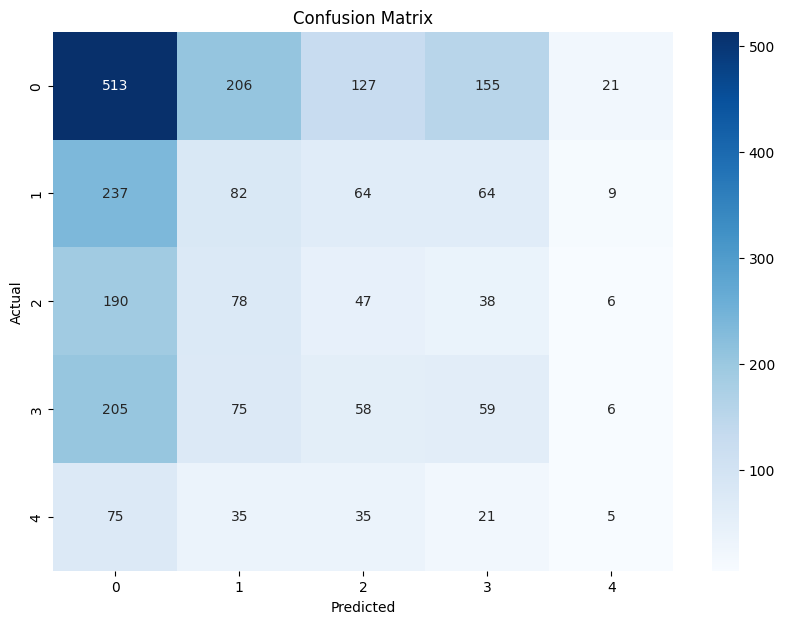

In [66]:
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true = test_df["race"]
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Augmentation

In [7]:
print(train_df["race"].value_counts())
print(val_df["race"].value_counts())

race
0    8177
1    3646
3    3221
2    2869
4    1368
Name: count, dtype: int64
race
0    1022
1     456
3     403
2     358
4     171
Name: count, dtype: int64


In [10]:
IMG_SIZE = 224
TARGET_PER_CLASS = 4500
AUG_SAVE_FOLDER = "/kaggle/working/augmented_dataset"
os.makedirs(AUG_SAVE_FOLDER, exist_ok=True)

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2],
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_df_aug = pd.concat([
    train_df[train_df['race'] != 0],
    train_df[train_df['race'] == 0].sample(n=4500, random_state=42)
])

In [11]:
def augment_images(df_label, label):
    output_dir = os.path.join(AUG_SAVE_FOLDER, str(label))
    os.makedirs(output_dir, exist_ok=True)

    for i, row in df_label.iterrows():
        shutil.copy(row['filepath'], os.path.join(output_dir, os.path.basename(row['filepath'])))

    total_existing = len(df_label)
    augment_needed = TARGET_PER_CLASS - total_existing
    if augment_needed <= 0:
        return

    x = []
    for f in df_label['filepath'].tolist():
        try:
            img = Image.open(f).convert('RGB').resize((IMG_SIZE, IMG_SIZE))
            x.append(np.array(img))
        except:
            continue
    x = np.array(x)

    gen = datagen.flow(x, batch_size=1, save_to_dir=output_dir,
                       save_prefix=f"aug_label{label}_", save_format='jpeg')
    
    for _ in range(augment_needed):
        next(gen)

for label in sorted(train_df_aug['race'].unique()):
    df_label = train_df_aug[train_df_aug['race'] == label]
    augment_images(df_label, label)

print("successful: ", AUG_SAVE_FOLDER)

successful:  /kaggle/working/augmented_dataset


In [12]:
import os
import pandas as pd

AUG_SAVE_FOLDER = "/kaggle/working/augmented_dataset"

data = []

for label in sorted(os.listdir(AUG_SAVE_FOLDER)):
    folder_path = os.path.join(AUG_SAVE_FOLDER, label)
    if os.path.isdir(folder_path):
        for fname in os.listdir(folder_path):
            if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                full_path = os.path.join(folder_path, fname)
                data.append((full_path, int(label)))

train_df_aug = pd.DataFrame(data, columns=["filepath", "label"])

print(train_df_aug['label'].value_counts())
train_df_aug.head()

label
0    4500
1    4500
2    4500
3    4500
4    4500
Name: count, dtype: int64


filepath  label
0  /kaggle/working/augmented_dataset/0/46_0_0_201...      0
1  /kaggle/working/augmented_dataset/0/73_0_0_201...      0
2  /kaggle/working/augmented_dataset/0/9_0_0_2017...      0
3  /kaggle/working/augmented_dataset/0/14_1_0_201...      0
4  /kaggle/working/augmented_dataset/0/32_0_0_201...      0

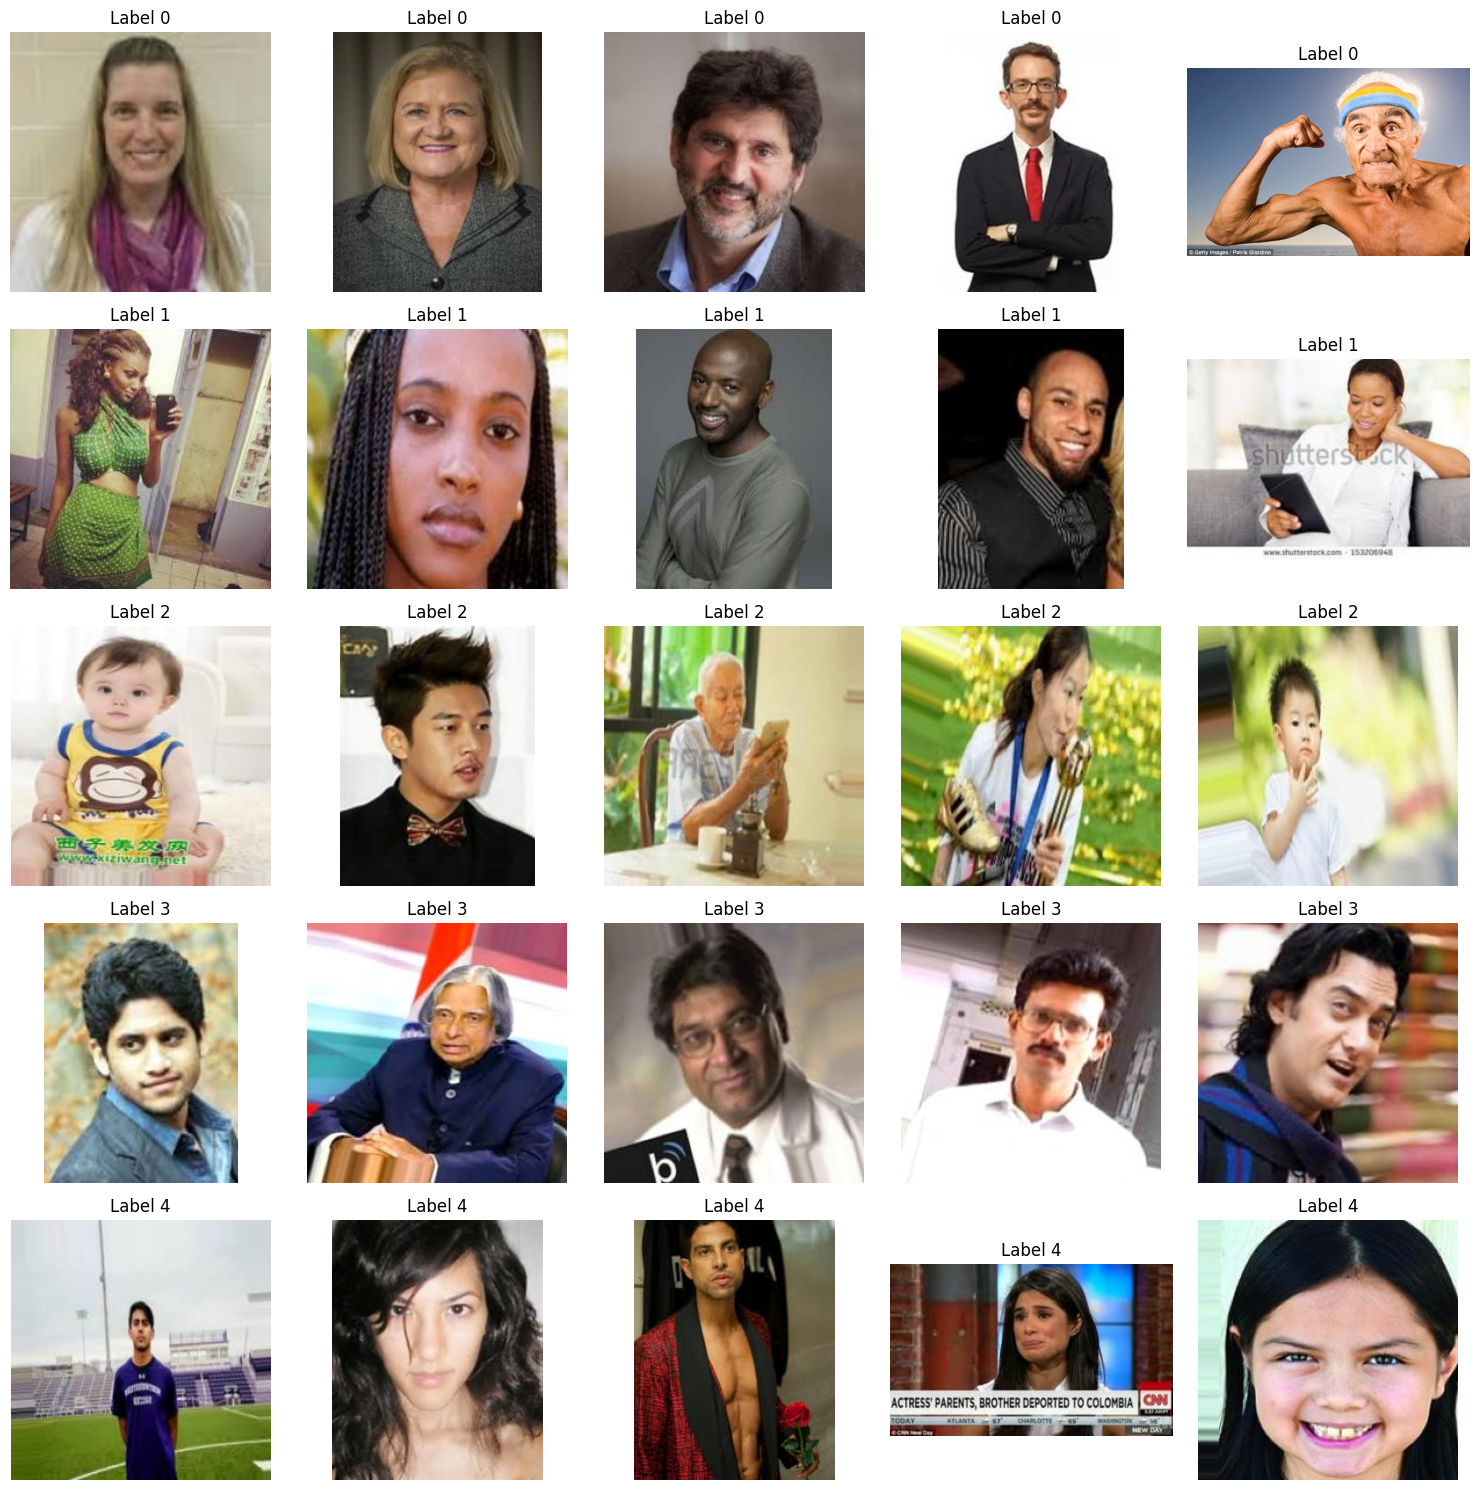

In [13]:
labels = sorted(train_df_aug['label'].unique())
num_samples = 5  

plt.figure(figsize=(num_samples * 3, len(labels) * 3))

for i, label in enumerate(labels):
    sample_rows = train_df_aug[train_df_aug['label'] == label].sample(num_samples, random_state=42)

    for j, filepath in enumerate(sample_rows['filepath'].values):
        img = Image.open(filepath).convert('RGB')

        plt_idx = i * num_samples + j + 1
        plt.subplot(len(labels), num_samples, plt_idx)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Label {label}')

plt.tight_layout()
plt.show()

In [51]:
train_df_aug = train_df_aug.sample(frac=1, random_state=42).reset_index(drop=True)
train_ds = make_dataset(train_df_aug, "label")

val_ds   = make_dataset(val_df, "race")
test_ds  = make_dataset(test_df, "race")

In [16]:
base = Xception(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), weights='imagenet')
base.trainable = False

model = models.Sequential([
    base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(5, activation='softmax') 
])
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 7, 7, 2048)          │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,140,909 (80.65 MB)

 Trainable params: 279,429 (1.07 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [17]:
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=3,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(train_ds, validation_data=val_ds, epochs=100, callbacks=[early_stop])

Epoch 1/100


I0000 00:00:1751655302.117237     106 service.cc:148] XLA service 0x798534002fb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751655302.120227     106 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1751655303.142018     106 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/704 ━━━━━━━━━━━━━━━━━━━━ 52s 75ms/step - accuracy: 0.2344 - loss: 1.6448   

I0000 00:00:1751655309.186764     106 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


704/704 ━━━━━━━━━━━━━━━━━━━━ 85s 100ms/step - accuracy: 0.3349 - loss: 1.5090 - val_accuracy: 0.5303 - val_loss: 1.2389
Epoch 2/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 61s 84ms/step - accuracy: 0.4668 - loss: 1.3113 - val_accuracy: 0.5320 - val_loss: 1.2174
Epoch 3/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 61s 85ms/step - accuracy: 0.5001 - loss: 1.2477 - val_accuracy: 0.5598 - val_loss: 1.1639
Epoch 4/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 61s 84ms/step - accuracy: 0.5273 - loss: 1.1956 - val_accuracy: 0.5469 - val_loss: 1.1689
Epoch 5/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 61s 85ms/step - accuracy: 0.5416 - loss: 1.1586 - val_accuracy: 0.5693 - val_loss: 1.1176
Epoch 6/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 61s 85ms/step - accuracy: 0.5619 - loss: 1.1156 - val_accuracy: 0.5726 - val_loss: 1.1114
Epoch 7/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 60s 84ms/step - accuracy: 0.5815 - loss: 1.0841 - val_accuracy: 0.5656 - val_loss: 1.1293
Epoch 8/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 61s 84ms/step - accuracy: 0.5978 - loss: 1.0509 - val

In [18]:
 model.evaluate(test_ds)

76/76 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - accuracy: 0.5577 - loss: 1.1322


[1.1229192018508911, 0.5649108290672302]

In [19]:
fig = px.line(history.history, y=['accuracy', 'val_accuracy'], 
              labels={'index': 'Epoch', 'value': 'Accuracy'}, 
              title='Training and Validation Accuracy',
              markers=True)
fig.update_traces(mode='markers+lines')
fig.show()

fig = px.line(history.history, y=['loss', 'val_loss'], 
              labels={'index': 'Epoch', 'value': 'Loss'}, 
              title='Training and Validation Loss',
              markers=True)
fig.update_traces(mode='markers+lines')
fig.show()

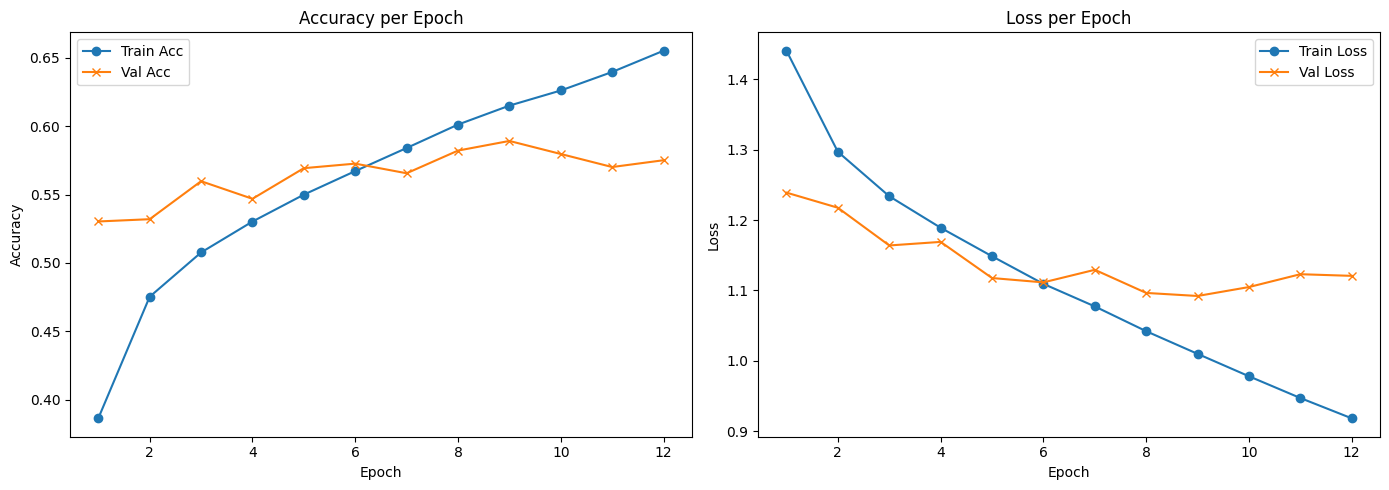

In [24]:
epochs = range(1, len(history.history['accuracy']) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['accuracy'], label='Train Acc', marker='o')
plt.plot(epochs, history.history['val_accuracy'], label='Val Acc', marker='x')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], label='Train Loss', marker='o')
plt.plot(epochs, history.history['val_loss'], label='Val Loss', marker='x')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

76/76 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step


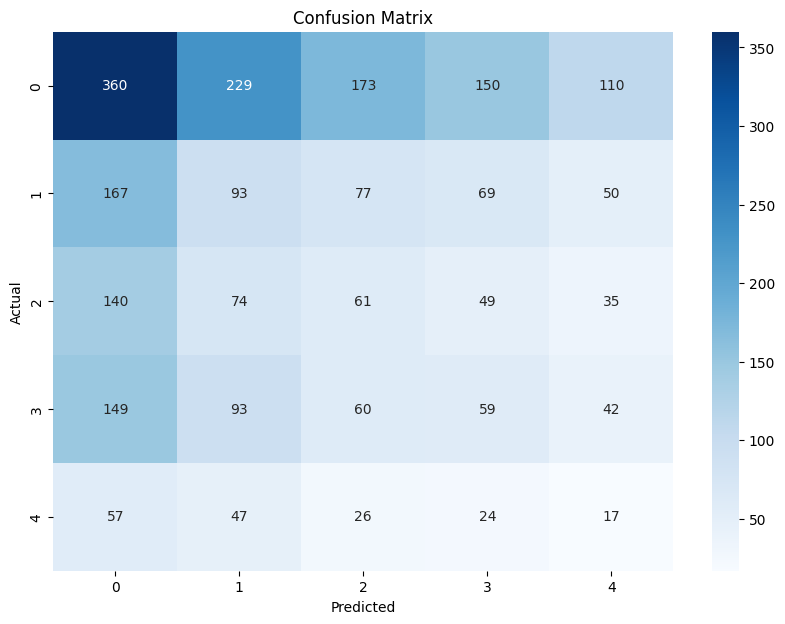

In [21]:
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true = test_df["race"]
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Model 2 (Output: Age)

In [27]:
train_ds   = make_dataset(train_df, "age")
val_ds   = make_dataset(val_df, "age")
test_ds  = make_dataset(test_df, "age")

In [35]:
model_age = models.Sequential([
    base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='linear')
])
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model_age.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

In [36]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=3,
    restore_best_weights=True,
    verbose=1
)

history = model_age.fit(train_ds, validation_data=val_ds, epochs=100, callbacks=[early_stop])

Epoch 1/100


Corrupt JPEG data: premature end of data segment


 43/603 ━━━━━━━━━━━━━━━━━━━━ 47s 84ms/step - loss: 1451.0909 - mae: 32.2833

Corrupt JPEG data: premature end of data segment


603/603 ━━━━━━━━━━━━━━━━━━━━ 71s 98ms/step - loss: 615.7090 - mae: 18.4947 - val_loss: 210.8631 - val_mae: 10.6250
Epoch 2/100


Corrupt JPEG data: premature end of data segment


 43/603 ━━━━━━━━━━━━━━━━━━━━ 48s 86ms/step - loss: 212.1882 - mae: 10.8451

Corrupt JPEG data: premature end of data segment


603/603 ━━━━━━━━━━━━━━━━━━━━ 55s 87ms/step - loss: 220.8422 - mae: 11.0133 - val_loss: 189.9575 - val_mae: 10.0706
Epoch 3/100


Corrupt JPEG data: premature end of data segment


 43/603 ━━━━━━━━━━━━━━━━━━━━ 46s 84ms/step - loss: 226.8533 - mae: 11.2407

Corrupt JPEG data: premature end of data segment


603/603 ━━━━━━━━━━━━━━━━━━━━ 54s 86ms/step - loss: 203.6186 - mae: 10.5345 - val_loss: 179.2707 - val_mae: 9.6465
Epoch 4/100


Corrupt JPEG data: premature end of data segment


 43/603 ━━━━━━━━━━━━━━━━━━━━ 48s 87ms/step - loss: 201.8031 - mae: 10.4996

Corrupt JPEG data: premature end of data segment


603/603 ━━━━━━━━━━━━━━━━━━━━ 55s 87ms/step - loss: 190.6364 - mae: 10.1427 - val_loss: 171.1283 - val_mae: 9.3679
Epoch 5/100


Corrupt JPEG data: premature end of data segment


 43/603 ━━━━━━━━━━━━━━━━━━━━ 46s 83ms/step - loss: 190.8803 - mae: 10.2744

Corrupt JPEG data: premature end of data segment


603/603 ━━━━━━━━━━━━━━━━━━━━ 55s 87ms/step - loss: 179.9288 - mae: 9.8003 - val_loss: 171.3330 - val_mae: 9.2486
Epoch 6/100


Corrupt JPEG data: premature end of data segment


 43/603 ━━━━━━━━━━━━━━━━━━━━ 46s 84ms/step - loss: 197.7642 - mae: 10.2891

Corrupt JPEG data: premature end of data segment


603/603 ━━━━━━━━━━━━━━━━━━━━ 54s 86ms/step - loss: 173.4364 - mae: 9.6307 - val_loss: 158.7411 - val_mae: 9.1340
Epoch 7/100


Corrupt JPEG data: premature end of data segment


 43/603 ━━━━━━━━━━━━━━━━━━━━ 46s 84ms/step - loss: 162.0718 - mae: 9.6025

Corrupt JPEG data: premature end of data segment


603/603 ━━━━━━━━━━━━━━━━━━━━ 55s 87ms/step - loss: 165.3043 - mae: 9.3702 - val_loss: 157.5558 - val_mae: 8.9348
Epoch 8/100


Corrupt JPEG data: premature end of data segment


 43/603 ━━━━━━━━━━━━━━━━━━━━ 46s 83ms/step - loss: 168.2801 - mae: 9.5956

Corrupt JPEG data: premature end of data segment


603/603 ━━━━━━━━━━━━━━━━━━━━ 54s 86ms/step - loss: 160.5978 - mae: 9.2245 - val_loss: 158.5882 - val_mae: 8.8706
Epoch 9/100


Corrupt JPEG data: premature end of data segment


 43/603 ━━━━━━━━━━━━━━━━━━━━ 47s 84ms/step - loss: 170.9997 - mae: 9.5503

Corrupt JPEG data: premature end of data segment


603/603 ━━━━━━━━━━━━━━━━━━━━ 55s 87ms/step - loss: 155.8817 - mae: 9.0857 - val_loss: 151.7144 - val_mae: 8.7682
Epoch 10/100


Corrupt JPEG data: premature end of data segment


 43/603 ━━━━━━━━━━━━━━━━━━━━ 46s 84ms/step - loss: 162.4641 - mae: 9.3615

Corrupt JPEG data: premature end of data segment


603/603 ━━━━━━━━━━━━━━━━━━━━ 54s 86ms/step - loss: 151.5488 - mae: 8.9843 - val_loss: 152.8812 - val_mae: 8.7239
Epoch 11/100


Corrupt JPEG data: premature end of data segment


 43/603 ━━━━━━━━━━━━━━━━━━━━ 47s 85ms/step - loss: 159.4481 - mae: 9.3012

Corrupt JPEG data: premature end of data segment


603/603 ━━━━━━━━━━━━━━━━━━━━ 54s 86ms/step - loss: 147.8398 - mae: 8.8396 - val_loss: 156.7221 - val_mae: 8.7587
Epoch 12/100


Corrupt JPEG data: premature end of data segment


 43/603 ━━━━━━━━━━━━━━━━━━━━ 46s 84ms/step - loss: 150.3984 - mae: 8.6394

Corrupt JPEG data: premature end of data segment


603/603 ━━━━━━━━━━━━━━━━━━━━ 54s 87ms/step - loss: 143.8151 - mae: 8.7049 - val_loss: 147.5495 - val_mae: 8.6910
Epoch 13/100


Corrupt JPEG data: premature end of data segment


 43/603 ━━━━━━━━━━━━━━━━━━━━ 47s 85ms/step - loss: 147.8814 - mae: 9.0078

Corrupt JPEG data: premature end of data segment


603/603 ━━━━━━━━━━━━━━━━━━━━ 54s 86ms/step - loss: 140.9457 - mae: 8.6054 - val_loss: 149.6171 - val_mae: 8.8413
Epoch 14/100


Corrupt JPEG data: premature end of data segment


 43/603 ━━━━━━━━━━━━━━━━━━━━ 49s 88ms/step - loss: 140.5625 - mae: 8.8440

Corrupt JPEG data: premature end of data segment


603/603 ━━━━━━━━━━━━━━━━━━━━ 54s 87ms/step - loss: 136.9071 - mae: 8.5265 - val_loss: 147.7537 - val_mae: 8.5531
Epoch 15/100


Corrupt JPEG data: premature end of data segment


 43/603 ━━━━━━━━━━━━━━━━━━━━ 47s 85ms/step - loss: 149.1639 - mae: 8.7659

Corrupt JPEG data: premature end of data segment


603/603 ━━━━━━━━━━━━━━━━━━━━ 54s 87ms/step - loss: 135.7471 - mae: 8.4722 - val_loss: 146.0224 - val_mae: 8.5596
Epoch 16/100


Corrupt JPEG data: premature end of data segment


 43/603 ━━━━━━━━━━━━━━━━━━━━ 47s 84ms/step - loss: 147.4441 - mae: 8.8293

Corrupt JPEG data: premature end of data segment


603/603 ━━━━━━━━━━━━━━━━━━━━ 54s 87ms/step - loss: 131.7391 - mae: 8.3542 - val_loss: 146.5804 - val_mae: 8.5084
Epoch 17/100


Corrupt JPEG data: premature end of data segment


 43/603 ━━━━━━━━━━━━━━━━━━━━ 46s 84ms/step - loss: 138.1154 - mae: 8.5186

Corrupt JPEG data: premature end of data segment


603/603 ━━━━━━━━━━━━━━━━━━━━ 54s 86ms/step - loss: 126.8216 - mae: 8.2189 - val_loss: 146.4417 - val_mae: 8.5139
Epoch 18/100


Corrupt JPEG data: premature end of data segment


 43/603 ━━━━━━━━━━━━━━━━━━━━ 47s 85ms/step - loss: 127.1335 - mae: 8.3430

Corrupt JPEG data: premature end of data segment


603/603 ━━━━━━━━━━━━━━━━━━━━ 54s 86ms/step - loss: 120.9585 - mae: 8.0407 - val_loss: 144.4566 - val_mae: 8.5469
Epoch 19/100


Corrupt JPEG data: premature end of data segment


 43/603 ━━━━━━━━━━━━━━━━━━━━ 46s 82ms/step - loss: 126.5612 - mae: 8.2540

Corrupt JPEG data: premature end of data segment


603/603 ━━━━━━━━━━━━━━━━━━━━ 54s 86ms/step - loss: 119.9265 - mae: 8.0012 - val_loss: 144.2943 - val_mae: 8.5058
Epoch 20/100


Corrupt JPEG data: premature end of data segment


 43/603 ━━━━━━━━━━━━━━━━━━━━ 46s 84ms/step - loss: 122.3665 - mae: 8.0818

Corrupt JPEG data: premature end of data segment


603/603 ━━━━━━━━━━━━━━━━━━━━ 54s 86ms/step - loss: 116.2910 - mae: 7.8897 - val_loss: 144.6605 - val_mae: 8.4575
Epoch 21/100


Corrupt JPEG data: premature end of data segment


 43/603 ━━━━━━━━━━━━━━━━━━━━ 46s 84ms/step - loss: 119.2881 - mae: 8.0208

Corrupt JPEG data: premature end of data segment


603/603 ━━━━━━━━━━━━━━━━━━━━ 54s 86ms/step - loss: 114.1132 - mae: 7.7888 - val_loss: 144.5625 - val_mae: 8.4666
Epoch 22/100


Corrupt JPEG data: premature end of data segment


 43/603 ━━━━━━━━━━━━━━━━━━━━ 46s 83ms/step - loss: 119.0199 - mae: 8.1581

Corrupt JPEG data: premature end of data segment


603/603 ━━━━━━━━━━━━━━━━━━━━ 54s 86ms/step - loss: 109.4198 - mae: 7.6832 - val_loss: 142.8564 - val_mae: 8.4486
Epoch 23/100


Corrupt JPEG data: premature end of data segment


 43/603 ━━━━━━━━━━━━━━━━━━━━ 46s 84ms/step - loss: 112.3763 - mae: 7.6956

Corrupt JPEG data: premature end of data segment


603/603 ━━━━━━━━━━━━━━━━━━━━ 54s 85ms/step - loss: 107.1456 - mae: 7.5566 - val_loss: 144.3400 - val_mae: 8.4398
Epoch 24/100


Corrupt JPEG data: premature end of data segment


 43/603 ━━━━━━━━━━━━━━━━━━━━ 47s 84ms/step - loss: 112.9889 - mae: 7.9376

Corrupt JPEG data: premature end of data segment


603/603 ━━━━━━━━━━━━━━━━━━━━ 54s 86ms/step - loss: 107.4371 - mae: 7.6048 - val_loss: 153.3311 - val_mae: 8.5898
Epoch 25/100


Corrupt JPEG data: premature end of data segment


 43/603 ━━━━━━━━━━━━━━━━━━━━ 46s 83ms/step - loss: 110.0293 - mae: 7.8455

Corrupt JPEG data: premature end of data segment


603/603 ━━━━━━━━━━━━━━━━━━━━ 54s 86ms/step - loss: 102.8222 - mae: 7.4655 - val_loss: 143.3102 - val_mae: 8.4537
Epoch 25: early stopping
Restoring model weights from the end of the best epoch: 22.


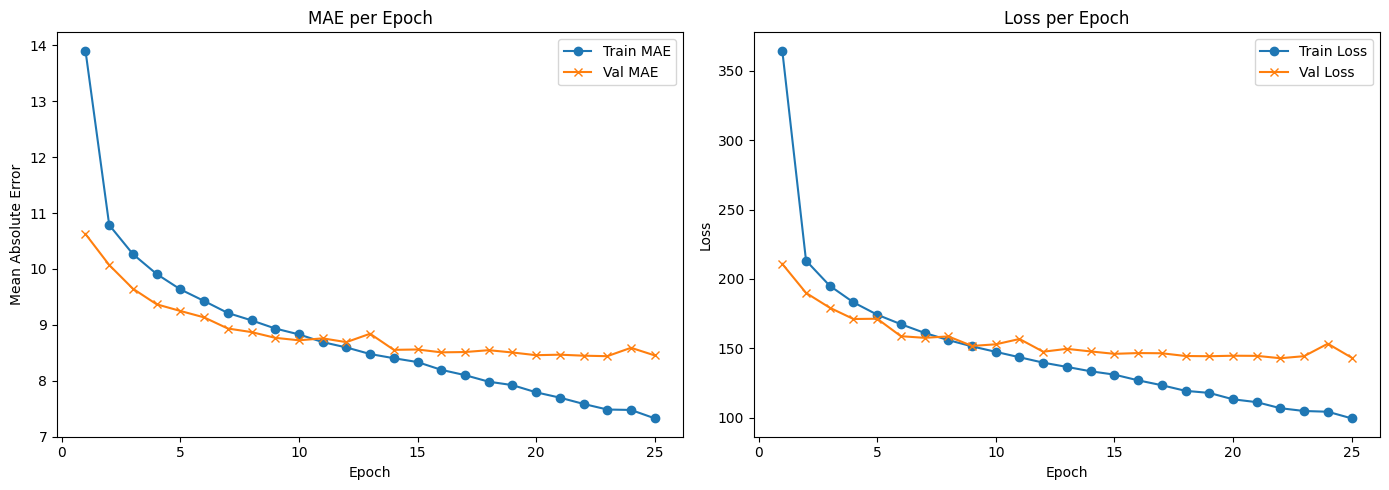

In [38]:
epochs = range(1, len(history.history['loss']) + 1)

plt.figure(figsize=(14, 5))

# Plot MAE (Mean Absolute Error)
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['mae'], label='Train MAE', marker='o')
plt.plot(epochs, history.history['val_mae'], label='Val MAE', marker='x')
plt.title('MAE per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], label='Train Loss', marker='o')
plt.plot(epochs, history.history['val_loss'], label='Val Loss', marker='x')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


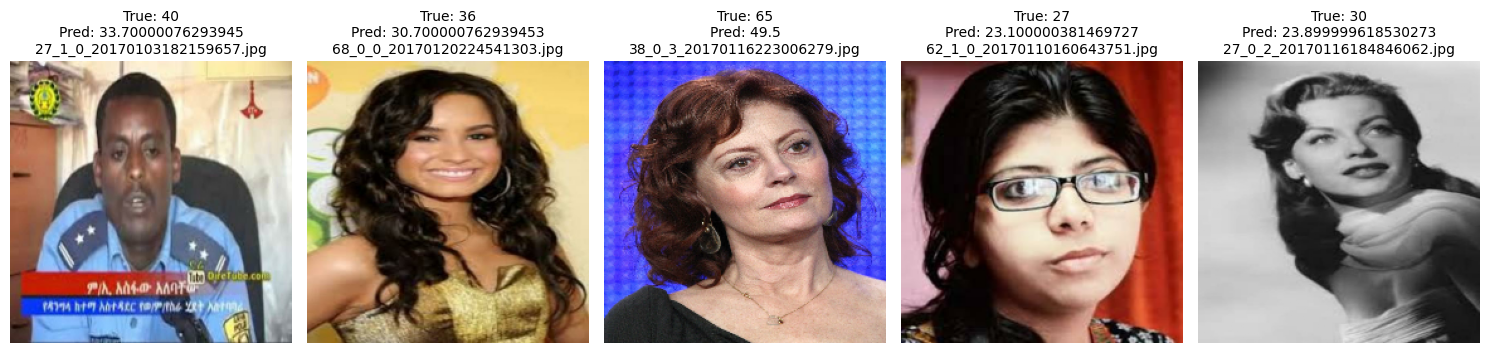

In [42]:
def show_predictions(model, dataset, df_ref, num_samples=5):
    for images, labels in dataset.take(1):
        preds = model.predict(images)
        preds = preds.flatten()
        labels = labels.numpy()

        plt.figure(figsize=(15, 4))
        for i in range(num_samples):
            ax = plt.subplot(1, num_samples, i+1)
            plt.imshow(images[i].numpy())
            true_age = int(labels[i])
            pred_age = round(preds[i], 1)
            fname = os.path.basename(df_ref.iloc[i]['filepath'])
            plt.title(f"True: {true_age}\nPred: {pred_age}\n{fname}", fontsize=10)
            plt.axis("off")
        plt.tight_layout()
        plt.show()

show_predictions(model_age, test_ds, test_df.reset_index(drop=True), num_samples=5)

# Model 3: Multioutput (gender, race, age)

In [7]:
IMG_SIZE = 224

def preprocess_multi_output(image_path, gender, race, age):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0
    return image, {'gender': gender, 'race': race, 'age': tf.cast(age, tf.float32)}

def multi_output_df(df):
    paths = df["filepath"].values
    gender_labels = df["gender"].values
    race_labels = df["race"].values
    age_labels = df["age"].values

    ds = tf.data.Dataset.from_tensor_slices((paths, gender_labels, race_labels, age_labels))
    ds = ds.map(preprocess_multi_output, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
    return ds

In [11]:
train_ds = multi_output_df(train_df)
val_ds = multi_output_df(val_df)
test_ds = multi_output_df(test_df)

In [8]:
IMG_SIZE = 224

base = Xception(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), weights='imagenet')
base.trainable = False

input_layer = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base(input_layer, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)

output_gender = layers.Dense(1, activation='sigmoid', name='gender')(x) 
output_race = layers.Dense(5, activation='softmax', name='race')(x)
output_age = layers.Dense(1, name='age')(x)

multi_output_model = models.Model(inputs=input_layer, outputs=[output_gender, output_race, output_age])
multi_output_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss={
        'gender': 'binary_crossentropy',
        'race': 'sparse_categorical_crossentropy',
        'age': 'mae'
    },
    metrics={
        'gender': 'accuracy',
        'race': 'accuracy',
        'age': 'mae'
    }
)

multi_output_model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ xception (Functional)     │ (None, 7, 7, 2048)     │     20,861,480 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 2048)           │              0 │ xception[0][0]         │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │        524,544 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gender (Dense)            │ (None, 1)              │            257 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ race (Dense)              │ (None, 5)              │          1,285 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ age (Dense)               │ (None, 1)              │            257 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 21,387,823 (81.59 MB)

 Trainable params: 526,343 (2.01 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [9]:
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=3,
    restore_best_weights=True,
    verbose=1
)

history = multi_output_model.fit(train_ds, validation_data=val_ds, epochs=50, callbacks=[early_stop])

Epoch 1/50


Corrupt JPEG data: premature end of data segment
I0000 00:00:1751669785.933046      99 service.cc:148] XLA service 0x7b6ad0140ce0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751669785.933779      99 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1751669786.968692      99 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/603 ━━━━━━━━━━━━━━━━━━━━ 46s 77ms/step - age_loss: 29.6220 - age_mae: 29.6220 - gender_accuracy: 0.5000 - gender_loss: 0.7294 - loss: 32.0236 - race_accuracy: 0.2734 - race_loss: 1.6722   

I0000 00:00:1751669792.371648      99 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 44/603 ━━━━━━━━━━━━━━━━━━━━ 1:14 133ms/step - age_loss: 30.5692 - age_mae: 30.5692 - gender_accuracy: 0.5110 - gender_loss: 0.7119 - loss: 32.8885 - race_accuracy: 0.3105 - race_loss: 1.6073

Corrupt JPEG data: premature end of data segment


603/603 ━━━━━━━━━━━━━━━━━━━━ 108s 149ms/step - age_loss: 19.0944 - age_mae: 19.0944 - gender_accuracy: 0.7001 - gender_loss: 0.5691 - loss: 21.3791 - race_accuracy: 0.3715 - race_loss: 1.7156 - val_age_loss: 11.3497 - val_age_mae: 11.3323 - val_gender_accuracy: 0.8539 - val_gender_loss: 0.3406 - val_loss: 12.8498 - val_race_accuracy: 0.5577 - val_race_loss: 1.1804
Epoch 2/50


Corrupt JPEG data: premature end of data segment


 43/603 ━━━━━━━━━━━━━━━━━━━━ 48s 87ms/step - age_loss: 12.3722 - age_mae: 12.3722 - gender_accuracy: 0.8250 - gender_loss: 0.4122 - loss: 14.4197 - race_accuracy: 0.4532 - race_loss: 1.6353

Corrupt JPEG data: premature end of data segment


603/603 ━━━━━━━━━━━━━━━━━━━━ 57s 91ms/step - age_loss: 11.3491 - age_mae: 11.3491 - gender_accuracy: 0.8350 - gender_loss: 0.3939 - loss: 13.2756 - race_accuracy: 0.4640 - race_loss: 1.5327 - val_age_loss: 10.6985 - val_age_mae: 10.6933 - val_gender_accuracy: 0.8568 - val_gender_loss: 0.3358 - val_loss: 12.1657 - val_race_accuracy: 0.5813 - val_race_loss: 1.1334
Epoch 3/50


Corrupt JPEG data: premature end of data segment


 42/603 ━━━━━━━━━━━━━━━━━━━━ 50s 90ms/step - age_loss: 10.8302 - age_mae: 10.8302 - gender_accuracy: 0.8624 - gender_loss: 0.3291 - loss: 12.5639 - race_accuracy: 0.4924 - race_loss: 1.4045

Corrupt JPEG data: premature end of data segment


603/603 ━━━━━━━━━━━━━━━━━━━━ 57s 91ms/step - age_loss: 10.7010 - age_mae: 10.7010 - gender_accuracy: 0.8546 - gender_loss: 0.3477 - loss: 12.4251 - race_accuracy: 0.5035 - race_loss: 1.3764 - val_age_loss: 10.3311 - val_age_mae: 10.3404 - val_gender_accuracy: 0.8656 - val_gender_loss: 0.3155 - val_loss: 11.7584 - val_race_accuracy: 0.5909 - val_race_loss: 1.1059
Epoch 4/50


Corrupt JPEG data: premature end of data segment


 42/603 ━━━━━━━━━━━━━━━━━━━━ 49s 88ms/step - age_loss: 10.5078 - age_mae: 10.5078 - gender_accuracy: 0.8417 - gender_loss: 0.3541 - loss: 12.1213 - race_accuracy: 0.5469 - race_loss: 1.2593

Corrupt JPEG data: premature end of data segment


603/603 ━━━━━━━━━━━━━━━━━━━━ 57s 90ms/step - age_loss: 10.3975 - age_mae: 10.3975 - gender_accuracy: 0.8574 - gender_loss: 0.3436 - loss: 12.0230 - race_accuracy: 0.5315 - race_loss: 1.2819 - val_age_loss: 10.1640 - val_age_mae: 10.1687 - val_gender_accuracy: 0.8676 - val_gender_loss: 0.3118 - val_loss: 11.5718 - val_race_accuracy: 0.5967 - val_race_loss: 1.0942
Epoch 5/50


Corrupt JPEG data: premature end of data segment


 42/603 ━━━━━━━━━━━━━━━━━━━━ 49s 87ms/step - age_loss: 10.8377 - age_mae: 10.8377 - gender_accuracy: 0.8527 - gender_loss: 0.3677 - loss: 12.4987 - race_accuracy: 0.5117 - race_loss: 1.2933

Corrupt JPEG data: premature end of data segment


603/603 ━━━━━━━━━━━━━━━━━━━━ 57s 90ms/step - age_loss: 10.1649 - age_mae: 10.1649 - gender_accuracy: 0.8656 - gender_loss: 0.3235 - loss: 11.7155 - race_accuracy: 0.5443 - race_loss: 1.2271 - val_age_loss: 9.9121 - val_age_mae: 9.9101 - val_gender_accuracy: 0.8714 - val_gender_loss: 0.3124 - val_loss: 11.2995 - val_race_accuracy: 0.5979 - val_race_loss: 1.0784
Epoch 6/50


Corrupt JPEG data: premature end of data segment


 42/603 ━━━━━━━━━━━━━━━━━━━━ 49s 89ms/step - age_loss: 10.1394 - age_mae: 10.1394 - gender_accuracy: 0.8662 - gender_loss: 0.3304 - loss: 11.7021 - race_accuracy: 0.5260 - race_loss: 1.2324

Corrupt JPEG data: premature end of data segment


603/603 ━━━━━━━━━━━━━━━━━━━━ 57s 91ms/step - age_loss: 9.9323 - age_mae: 9.9323 - gender_accuracy: 0.8683 - gender_loss: 0.3171 - loss: 11.4393 - race_accuracy: 0.5528 - race_loss: 1.1899 - val_age_loss: 9.7536 - val_age_mae: 9.7488 - val_gender_accuracy: 0.8734 - val_gender_loss: 0.3061 - val_loss: 11.1225 - val_race_accuracy: 0.6104 - val_race_loss: 1.0695
Epoch 7/50


Corrupt JPEG data: premature end of data segment


 42/603 ━━━━━━━━━━━━━━━━━━━━ 49s 87ms/step - age_loss: 10.0053 - age_mae: 10.0053 - gender_accuracy: 0.8772 - gender_loss: 0.2982 - loss: 11.4618 - race_accuracy: 0.5636 - race_loss: 1.1584

Corrupt JPEG data: premature end of data segment


603/603 ━━━━━━━━━━━━━━━━━━━━ 57s 90ms/step - age_loss: 9.7894 - age_mae: 9.7894 - gender_accuracy: 0.8751 - gender_loss: 0.3004 - loss: 11.2345 - race_accuracy: 0.5768 - race_loss: 1.1447 - val_age_loss: 9.6253 - val_age_mae: 9.6000 - val_gender_accuracy: 0.8710 - val_gender_loss: 0.3030 - val_loss: 10.9613 - val_race_accuracy: 0.6091 - val_race_loss: 1.0546
Epoch 8/50


Corrupt JPEG data: premature end of data segment


 42/603 ━━━━━━━━━━━━━━━━━━━━ 49s 88ms/step - age_loss: 10.3628 - age_mae: 10.3628 - gender_accuracy: 0.8719 - gender_loss: 0.2827 - loss: 11.8555 - race_accuracy: 0.5498 - race_loss: 1.2100

Corrupt JPEG data: premature end of data segment


603/603 ━━━━━━━━━━━━━━━━━━━━ 57s 91ms/step - age_loss: 9.7165 - age_mae: 9.7165 - gender_accuracy: 0.8751 - gender_loss: 0.2936 - loss: 11.1322 - race_accuracy: 0.5820 - race_loss: 1.1221 - val_age_loss: 9.5066 - val_age_mae: 9.4786 - val_gender_accuracy: 0.8697 - val_gender_loss: 0.3011 - val_loss: 10.8354 - val_race_accuracy: 0.6137 - val_race_loss: 1.0571
Epoch 9/50


Corrupt JPEG data: premature end of data segment


 43/603 ━━━━━━━━━━━━━━━━━━━━ 48s 87ms/step - age_loss: 9.8357 - age_mae: 9.8357 - gender_accuracy: 0.8692 - gender_loss: 0.3183 - loss: 11.2795 - race_accuracy: 0.5798 - race_loss: 1.1255

Corrupt JPEG data: premature end of data segment


603/603 ━━━━━━━━━━━━━━━━━━━━ 57s 90ms/step - age_loss: 9.5322 - age_mae: 9.5322 - gender_accuracy: 0.8774 - gender_loss: 0.2983 - loss: 10.9263 - race_accuracy: 0.5880 - race_loss: 1.0958 - val_age_loss: 9.3504 - val_age_mae: 9.3917 - val_gender_accuracy: 0.8726 - val_gender_loss: 0.2978 - val_loss: 10.7393 - val_race_accuracy: 0.6166 - val_race_loss: 1.0479
Epoch 10/50


Corrupt JPEG data: premature end of data segment


 43/603 ━━━━━━━━━━━━━━━━━━━━ 49s 88ms/step - age_loss: 9.8616 - age_mae: 9.8616 - gender_accuracy: 0.8644 - gender_loss: 0.3198 - loss: 11.2780 - race_accuracy: 0.5880 - race_loss: 1.0967

Corrupt JPEG data: premature end of data segment


603/603 ━━━━━━━━━━━━━━━━━━━━ 57s 90ms/step - age_loss: 9.3938 - age_mae: 9.3938 - gender_accuracy: 0.8813 - gender_loss: 0.2899 - loss: 10.7481 - race_accuracy: 0.5990 - race_loss: 1.0644 - val_age_loss: 9.3082 - val_age_mae: 9.3146 - val_gender_accuracy: 0.8730 - val_gender_loss: 0.2985 - val_loss: 10.6557 - val_race_accuracy: 0.6199 - val_race_loss: 1.0445
Epoch 11/50


Corrupt JPEG data: premature end of data segment


 43/603 ━━━━━━━━━━━━━━━━━━━━ 49s 88ms/step - age_loss: 9.9468 - age_mae: 9.9468 - gender_accuracy: 0.8887 - gender_loss: 0.2840 - loss: 11.3183 - race_accuracy: 0.6220 - race_loss: 1.0875

Corrupt JPEG data: premature end of data segment


603/603 ━━━━━━━━━━━━━━━━━━━━ 57s 90ms/step - age_loss: 9.3815 - age_mae: 9.3815 - gender_accuracy: 0.8836 - gender_loss: 0.2866 - loss: 10.7117 - race_accuracy: 0.6144 - race_loss: 1.0436 - val_age_loss: 9.3687 - val_age_mae: 9.3958 - val_gender_accuracy: 0.8714 - val_gender_loss: 0.2983 - val_loss: 10.7345 - val_race_accuracy: 0.6212 - val_race_loss: 1.0413
Epoch 12/50


Corrupt JPEG data: premature end of data segment


 42/603 ━━━━━━━━━━━━━━━━━━━━ 51s 92ms/step - age_loss: 9.8473 - age_mae: 9.8473 - gender_accuracy: 0.8716 - gender_loss: 0.3093 - loss: 11.1671 - race_accuracy: 0.6106 - race_loss: 1.0105

Corrupt JPEG data: premature end of data segment


603/603 ━━━━━━━━━━━━━━━━━━━━ 57s 90ms/step - age_loss: 9.2600 - age_mae: 9.2600 - gender_accuracy: 0.8855 - gender_loss: 0.2802 - loss: 10.5679 - race_accuracy: 0.6157 - race_loss: 1.0278 - val_age_loss: 9.1705 - val_age_mae: 9.1852 - val_gender_accuracy: 0.8734 - val_gender_loss: 0.2956 - val_loss: 10.5143 - val_race_accuracy: 0.6241 - val_race_loss: 1.0331
Epoch 13/50


Corrupt JPEG data: premature end of data segment


 42/603 ━━━━━━━━━━━━━━━━━━━━ 48s 87ms/step - age_loss: 9.5533 - age_mae: 9.5533 - gender_accuracy: 0.8781 - gender_loss: 0.2907 - loss: 10.8895 - race_accuracy: 0.6126 - race_loss: 1.0455

Corrupt JPEG data: premature end of data segment


603/603 ━━━━━━━━━━━━━━━━━━━━ 57s 90ms/step - age_loss: 9.1302 - age_mae: 9.1302 - gender_accuracy: 0.8835 - gender_loss: 0.2835 - loss: 10.4293 - race_accuracy: 0.6211 - race_loss: 1.0156 - val_age_loss: 9.1220 - val_age_mae: 9.1525 - val_gender_accuracy: 0.8705 - val_gender_loss: 0.3003 - val_loss: 10.4893 - val_race_accuracy: 0.6232 - val_race_loss: 1.0379
Epoch 14/50


Corrupt JPEG data: premature end of data segment


 42/603 ━━━━━━━━━━━━━━━━━━━━ 49s 87ms/step - age_loss: 9.3325 - age_mae: 9.3325 - gender_accuracy: 0.8822 - gender_loss: 0.2695 - loss: 10.6236 - race_accuracy: 0.6166 - race_loss: 1.0215

Corrupt JPEG data: premature end of data segment


603/603 ━━━━━━━━━━━━━━━━━━━━ 57s 90ms/step - age_loss: 9.0850 - age_mae: 9.0850 - gender_accuracy: 0.8869 - gender_loss: 0.2724 - loss: 10.3612 - race_accuracy: 0.6269 - race_loss: 1.0038 - val_age_loss: 9.0877 - val_age_mae: 9.0876 - val_gender_accuracy: 0.8722 - val_gender_loss: 0.2928 - val_loss: 10.4144 - val_race_accuracy: 0.6228 - val_race_loss: 1.0328
Epoch 15/50


Corrupt JPEG data: premature end of data segment


 43/603 ━━━━━━━━━━━━━━━━━━━━ 48s 87ms/step - age_loss: 9.0224 - age_mae: 9.0224 - gender_accuracy: 0.8942 - gender_loss: 0.2736 - loss: 10.3255 - race_accuracy: 0.6021 - race_loss: 1.0295

Corrupt JPEG data: premature end of data segment


603/603 ━━━━━━━━━━━━━━━━━━━━ 57s 90ms/step - age_loss: 8.9880 - age_mae: 8.9879 - gender_accuracy: 0.8896 - gender_loss: 0.2707 - loss: 10.2498 - race_accuracy: 0.6277 - race_loss: 0.9911 - val_age_loss: 9.0720 - val_age_mae: 9.1047 - val_gender_accuracy: 0.8722 - val_gender_loss: 0.2933 - val_loss: 10.4270 - val_race_accuracy: 0.6257 - val_race_loss: 1.0330
Epoch 16/50


Corrupt JPEG data: premature end of data segment


 43/603 ━━━━━━━━━━━━━━━━━━━━ 49s 88ms/step - age_loss: 9.1221 - age_mae: 9.1221 - gender_accuracy: 0.9019 - gender_loss: 0.2667 - loss: 10.4372 - race_accuracy: 0.6048 - race_loss: 1.0484

Corrupt JPEG data: premature end of data segment


603/603 ━━━━━━━━━━━━━━━━━━━━ 57s 90ms/step - age_loss: 8.9377 - age_mae: 8.9377 - gender_accuracy: 0.8946 - gender_loss: 0.2651 - loss: 10.1852 - race_accuracy: 0.6314 - race_loss: 0.9824 - val_age_loss: 8.9731 - val_age_mae: 9.0005 - val_gender_accuracy: 0.8734 - val_gender_loss: 0.2912 - val_loss: 10.3185 - val_race_accuracy: 0.6295 - val_race_loss: 1.0253
Epoch 17/50


Corrupt JPEG data: premature end of data segment


 43/603 ━━━━━━━━━━━━━━━━━━━━ 48s 87ms/step - age_loss: 9.3629 - age_mae: 9.3629 - gender_accuracy: 0.8840 - gender_loss: 0.2681 - loss: 10.6639 - race_accuracy: 0.6414 - race_loss: 1.0330

Corrupt JPEG data: premature end of data segment


603/603 ━━━━━━━━━━━━━━━━━━━━ 57s 90ms/step - age_loss: 8.9444 - age_mae: 8.9444 - gender_accuracy: 0.8891 - gender_loss: 0.2664 - loss: 10.1793 - race_accuracy: 0.6424 - race_loss: 0.9686 - val_age_loss: 8.9864 - val_age_mae: 8.9524 - val_gender_accuracy: 0.8751 - val_gender_loss: 0.2907 - val_loss: 10.2684 - val_race_accuracy: 0.6295 - val_race_loss: 1.0252
Epoch 18/50


Corrupt JPEG data: premature end of data segment


 43/603 ━━━━━━━━━━━━━━━━━━━━ 49s 89ms/step - age_loss: 9.6908 - age_mae: 9.6908 - gender_accuracy: 0.8946 - gender_loss: 0.2866 - loss: 10.9491 - race_accuracy: 0.6526 - race_loss: 0.9717

Corrupt JPEG data: premature end of data segment


603/603 ━━━━━━━━━━━━━━━━━━━━ 57s 90ms/step - age_loss: 8.8811 - age_mae: 8.8811 - gender_accuracy: 0.8952 - gender_loss: 0.2626 - loss: 10.1037 - race_accuracy: 0.6483 - race_loss: 0.9600 - val_age_loss: 9.0009 - val_age_mae: 8.9798 - val_gender_accuracy: 0.8722 - val_gender_loss: 0.2954 - val_loss: 10.3019 - val_race_accuracy: 0.6232 - val_race_loss: 1.0234
Epoch 19/50


Corrupt JPEG data: premature end of data segment


 43/603 ━━━━━━━━━━━━━━━━━━━━ 49s 89ms/step - age_loss: 9.3042 - age_mae: 9.3042 - gender_accuracy: 0.8731 - gender_loss: 0.3044 - loss: 10.5945 - race_accuracy: 0.6308 - race_loss: 0.9860

Corrupt JPEG data: premature end of data segment


603/603 ━━━━━━━━━━━━━━━━━━━━ 56s 90ms/step - age_loss: 8.8447 - age_mae: 8.8447 - gender_accuracy: 0.8914 - gender_loss: 0.2666 - loss: 10.0549 - race_accuracy: 0.6505 - race_loss: 0.9436 - val_age_loss: 8.8903 - val_age_mae: 8.9013 - val_gender_accuracy: 0.8768 - val_gender_loss: 0.2911 - val_loss: 10.2180 - val_race_accuracy: 0.6307 - val_race_loss: 1.0252
Epoch 20/50


Corrupt JPEG data: premature end of data segment


 42/603 ━━━━━━━━━━━━━━━━━━━━ 49s 88ms/step - age_loss: 9.0229 - age_mae: 9.0229 - gender_accuracy: 0.9012 - gender_loss: 0.2543 - loss: 10.2034 - race_accuracy: 0.6456 - race_loss: 0.9262

Corrupt JPEG data: premature end of data segment


603/603 ━━━━━━━━━━━━━━━━━━━━ 56s 89ms/step - age_loss: 8.6938 - age_mae: 8.6938 - gender_accuracy: 0.8981 - gender_loss: 0.2601 - loss: 9.8918 - race_accuracy: 0.6505 - race_loss: 0.9379 - val_age_loss: 8.8838 - val_age_mae: 8.8866 - val_gender_accuracy: 0.8751 - val_gender_loss: 0.2900 - val_loss: 10.1976 - val_race_accuracy: 0.6286 - val_race_loss: 1.0202
Epoch 21/50


Corrupt JPEG data: premature end of data segment


 43/603 ━━━━━━━━━━━━━━━━━━━━ 49s 88ms/step - age_loss: 8.7965 - age_mae: 8.7965 - gender_accuracy: 0.8846 - gender_loss: 0.2616 - loss: 9.9915 - race_accuracy: 0.6641 - race_loss: 0.9333

Corrupt JPEG data: premature end of data segment


603/603 ━━━━━━━━━━━━━━━━━━━━ 56s 90ms/step - age_loss: 8.6088 - age_mae: 8.6088 - gender_accuracy: 0.8979 - gender_loss: 0.2517 - loss: 9.7860 - race_accuracy: 0.6627 - race_loss: 0.9254 - val_age_loss: 8.8562 - val_age_mae: 8.8448 - val_gender_accuracy: 0.8751 - val_gender_loss: 0.2874 - val_loss: 10.1549 - val_race_accuracy: 0.6324 - val_race_loss: 1.0164
Epoch 22/50


Corrupt JPEG data: premature end of data segment


 42/603 ━━━━━━━━━━━━━━━━━━━━ 49s 88ms/step - age_loss: 9.4234 - age_mae: 9.4234 - gender_accuracy: 0.8807 - gender_loss: 0.2515 - loss: 10.6027 - race_accuracy: 0.6741 - race_loss: 0.9279

Corrupt JPEG data: premature end of data segment


603/603 ━━━━━━━━━━━━━━━━━━━━ 56s 90ms/step - age_loss: 8.6241 - age_mae: 8.6241 - gender_accuracy: 0.8955 - gender_loss: 0.2538 - loss: 9.7903 - race_accuracy: 0.6644 - race_loss: 0.9124 - val_age_loss: 8.8623 - val_age_mae: 8.8352 - val_gender_accuracy: 0.8739 - val_gender_loss: 0.2876 - val_loss: 10.1448 - val_race_accuracy: 0.6274 - val_race_loss: 1.0228
Epoch 23/50


Corrupt JPEG data: premature end of data segment


 42/603 ━━━━━━━━━━━━━━━━━━━━ 48s 87ms/step - age_loss: 8.6960 - age_mae: 8.6960 - gender_accuracy: 0.9108 - gender_loss: 0.2220 - loss: 9.8127 - race_accuracy: 0.6700 - race_loss: 0.8947

Corrupt JPEG data: premature end of data segment


603/603 ━━━━━━━━━━━━━━━━━━━━ 56s 90ms/step - age_loss: 8.5232 - age_mae: 8.5232 - gender_accuracy: 0.8990 - gender_loss: 0.2462 - loss: 9.6752 - race_accuracy: 0.6685 - race_loss: 0.9058 - val_age_loss: 8.7859 - val_age_mae: 8.8053 - val_gender_accuracy: 0.8730 - val_gender_loss: 0.2910 - val_loss: 10.1127 - val_race_accuracy: 0.6286 - val_race_loss: 1.0209
Epoch 24/50


Corrupt JPEG data: premature end of data segment


 42/603 ━━━━━━━━━━━━━━━━━━━━ 49s 88ms/step - age_loss: 9.3035 - age_mae: 9.3035 - gender_accuracy: 0.8917 - gender_loss: 0.2901 - loss: 10.5166 - race_accuracy: 0.6546 - race_loss: 0.9230

Corrupt JPEG data: premature end of data segment


603/603 ━━━━━━━━━━━━━━━━━━━━ 56s 89ms/step - age_loss: 8.5262 - age_mae: 8.5262 - gender_accuracy: 0.8995 - gender_loss: 0.2515 - loss: 9.6818 - race_accuracy: 0.6661 - race_loss: 0.9041 - val_age_loss: 8.8103 - val_age_mae: 8.8145 - val_gender_accuracy: 0.8743 - val_gender_loss: 0.2856 - val_loss: 10.1190 - val_race_accuracy: 0.6336 - val_race_loss: 1.0187
Epoch 25/50


Corrupt JPEG data: premature end of data segment


 43/603 ━━━━━━━━━━━━━━━━━━━━ 49s 88ms/step - age_loss: 8.7982 - age_mae: 8.7982 - gender_accuracy: 0.8816 - gender_loss: 0.2679 - loss: 9.9975 - race_accuracy: 0.6646 - race_loss: 0.9315 

Corrupt JPEG data: premature end of data segment


603/603 ━━━━━━━━━━━━━━━━━━━━ 57s 90ms/step - age_loss: 8.4668 - age_mae: 8.4668 - gender_accuracy: 0.8985 - gender_loss: 0.2497 - loss: 9.6162 - race_accuracy: 0.6677 - race_loss: 0.8996 - val_age_loss: 8.7604 - val_age_mae: 8.7705 - val_gender_accuracy: 0.8743 - val_gender_loss: 0.2848 - val_loss: 10.0790 - val_race_accuracy: 0.6353 - val_race_loss: 1.0239
Epoch 26/50


Corrupt JPEG data: premature end of data segment


 42/603 ━━━━━━━━━━━━━━━━━━━━ 48s 86ms/step - age_loss: 8.5146 - age_mae: 8.5146 - gender_accuracy: 0.8857 - gender_loss: 0.2574 - loss: 9.6480 - race_accuracy: 0.6789 - race_loss: 0.8760

Corrupt JPEG data: premature end of data segment


603/603 ━━━━━━━━━━━━━━━━━━━━ 56s 90ms/step - age_loss: 8.4063 - age_mae: 8.4063 - gender_accuracy: 0.9004 - gender_loss: 0.2454 - loss: 9.5331 - race_accuracy: 0.6768 - race_loss: 0.8814 - val_age_loss: 8.7360 - val_age_mae: 8.7597 - val_gender_accuracy: 0.8759 - val_gender_loss: 0.2876 - val_loss: 10.0662 - val_race_accuracy: 0.6324 - val_race_loss: 1.0189
Epoch 27/50


Corrupt JPEG data: premature end of data segment


 42/603 ━━━━━━━━━━━━━━━━━━━━ 48s 87ms/step - age_loss: 9.0137 - age_mae: 9.0137 - gender_accuracy: 0.8992 - gender_loss: 0.2642 - loss: 10.1690 - race_accuracy: 0.6759 - race_loss: 0.8910

Corrupt JPEG data: premature end of data segment


603/603 ━━━━━━━━━━━━━━━━━━━━ 56s 90ms/step - age_loss: 8.4047 - age_mae: 8.4047 - gender_accuracy: 0.9045 - gender_loss: 0.2454 - loss: 9.5288 - race_accuracy: 0.6732 - race_loss: 0.8787 - val_age_loss: 8.7097 - val_age_mae: 8.7378 - val_gender_accuracy: 0.8780 - val_gender_loss: 0.2883 - val_loss: 10.0419 - val_race_accuracy: 0.6349 - val_race_loss: 1.0138
Epoch 28/50


Corrupt JPEG data: premature end of data segment


 43/603 ━━━━━━━━━━━━━━━━━━━━ 48s 87ms/step - age_loss: 8.6170 - age_mae: 8.6170 - gender_accuracy: 0.9039 - gender_loss: 0.2242 - loss: 9.6957 - race_accuracy: 0.6889 - race_loss: 0.8545

Corrupt JPEG data: premature end of data segment


603/603 ━━━━━━━━━━━━━━━━━━━━ 56s 90ms/step - age_loss: 8.2878 - age_mae: 8.2878 - gender_accuracy: 0.9044 - gender_loss: 0.2412 - loss: 9.4014 - race_accuracy: 0.6847 - race_loss: 0.8724 - val_age_loss: 8.7818 - val_age_mae: 8.7505 - val_gender_accuracy: 0.8763 - val_gender_loss: 0.2923 - val_loss: 10.0548 - val_race_accuracy: 0.6365 - val_race_loss: 1.0147
Epoch 29/50


Corrupt JPEG data: premature end of data segment


 43/603 ━━━━━━━━━━━━━━━━━━━━ 51s 92ms/step - age_loss: 8.4815 - age_mae: 8.4815 - gender_accuracy: 0.8929 - gender_loss: 0.2476 - loss: 9.5911 - race_accuracy: 0.6911 - race_loss: 0.8620

Corrupt JPEG data: premature end of data segment


603/603 ━━━━━━━━━━━━━━━━━━━━ 56s 90ms/step - age_loss: 8.2314 - age_mae: 8.2314 - gender_accuracy: 0.9008 - gender_loss: 0.2421 - loss: 9.3336 - race_accuracy: 0.6855 - race_loss: 0.8601 - val_age_loss: 8.7267 - val_age_mae: 8.7413 - val_gender_accuracy: 0.8797 - val_gender_loss: 0.2899 - val_loss: 10.0475 - val_race_accuracy: 0.6270 - val_race_loss: 1.0154
Epoch 30/50


Corrupt JPEG data: premature end of data segment


 42/603 ━━━━━━━━━━━━━━━━━━━━ 49s 88ms/step - age_loss: 8.6548 - age_mae: 8.6548 - gender_accuracy: 0.8854 - gender_loss: 0.2546 - loss: 9.7974 - race_accuracy: 0.6885 - race_loss: 0.8880

Corrupt JPEG data: premature end of data segment


603/603 ━━━━━━━━━━━━━━━━━━━━ 57s 91ms/step - age_loss: 8.2386 - age_mae: 8.2386 - gender_accuracy: 0.9015 - gender_loss: 0.2412 - loss: 9.3359 - race_accuracy: 0.6921 - race_loss: 0.8561 - val_age_loss: 8.7088 - val_age_mae: 8.7240 - val_gender_accuracy: 0.8726 - val_gender_loss: 0.2881 - val_loss: 10.0284 - val_race_accuracy: 0.6361 - val_race_loss: 1.0149
Epoch 31/50


Corrupt JPEG data: premature end of data segment


 43/603 ━━━━━━━━━━━━━━━━━━━━ 48s 86ms/step - age_loss: 8.8365 - age_mae: 8.8365 - gender_accuracy: 0.9052 - gender_loss: 0.2510 - loss: 9.9327 - race_accuracy: 0.6928 - race_loss: 0.8452

Corrupt JPEG data: premature end of data segment


603/603 ━━━━━━━━━━━━━━━━━━━━ 56s 90ms/step - age_loss: 8.1992 - age_mae: 8.1992 - gender_accuracy: 0.9059 - gender_loss: 0.2393 - loss: 9.2921 - race_accuracy: 0.6888 - race_loss: 0.8535 - val_age_loss: 8.7200 - val_age_mae: 8.6992 - val_gender_accuracy: 0.8780 - val_gender_loss: 0.2876 - val_loss: 10.0081 - val_race_accuracy: 0.6340 - val_race_loss: 1.0163
Epoch 32/50


Corrupt JPEG data: premature end of data segment


 43/603 ━━━━━━━━━━━━━━━━━━━━ 48s 87ms/step - age_loss: 8.3125 - age_mae: 8.3125 - gender_accuracy: 0.9094 - gender_loss: 0.2228 - loss: 9.4125 - race_accuracy: 0.6824 - race_loss: 0.8772

Corrupt JPEG data: premature end of data segment


603/603 ━━━━━━━━━━━━━━━━━━━━ 56s 89ms/step - age_loss: 8.1073 - age_mae: 8.1073 - gender_accuracy: 0.9074 - gender_loss: 0.2347 - loss: 9.1902 - race_accuracy: 0.6918 - race_loss: 0.8482 - val_age_loss: 8.6346 - val_age_mae: 8.6651 - val_gender_accuracy: 0.8772 - val_gender_loss: 0.2854 - val_loss: 9.9721 - val_race_accuracy: 0.6336 - val_race_loss: 1.0162
Epoch 33/50


Corrupt JPEG data: premature end of data segment


 43/603 ━━━━━━━━━━━━━━━━━━━━ 50s 90ms/step - age_loss: 8.0766 - age_mae: 8.0766 - gender_accuracy: 0.9079 - gender_loss: 0.2273 - loss: 9.1680 - race_accuracy: 0.6686 - race_loss: 0.8640

Corrupt JPEG data: premature end of data segment


603/603 ━━━━━━━━━━━━━━━━━━━━ 57s 90ms/step - age_loss: 8.0502 - age_mae: 8.0502 - gender_accuracy: 0.9051 - gender_loss: 0.2359 - loss: 9.1205 - race_accuracy: 0.6914 - race_loss: 0.8344 - val_age_loss: 8.6657 - val_age_mae: 8.6511 - val_gender_accuracy: 0.8793 - val_gender_loss: 0.2875 - val_loss: 9.9539 - val_race_accuracy: 0.6386 - val_race_loss: 1.0154
Epoch 34/50


Corrupt JPEG data: premature end of data segment


 43/603 ━━━━━━━━━━━━━━━━━━━━ 49s 88ms/step - age_loss: 8.5594 - age_mae: 8.5594 - gender_accuracy: 0.8973 - gender_loss: 0.2553 - loss: 9.7312 - race_accuracy: 0.6654 - race_loss: 0.9165

Corrupt JPEG data: premature end of data segment


603/603 ━━━━━━━━━━━━━━━━━━━━ 56s 90ms/step - age_loss: 8.0933 - age_mae: 8.0933 - gender_accuracy: 0.9062 - gender_loss: 0.2350 - loss: 9.1679 - race_accuracy: 0.6938 - race_loss: 0.8395 - val_age_loss: 8.6748 - val_age_mae: 8.6639 - val_gender_accuracy: 0.8776 - val_gender_loss: 0.2881 - val_loss: 9.9696 - val_race_accuracy: 0.6386 - val_race_loss: 1.0154
Epoch 35/50


Corrupt JPEG data: premature end of data segment


 43/603 ━━━━━━━━━━━━━━━━━━━━ 49s 88ms/step - age_loss: 8.3774 - age_mae: 8.3774 - gender_accuracy: 0.8905 - gender_loss: 0.2450 - loss: 9.4661 - race_accuracy: 0.6842 - race_loss: 0.8436

Corrupt JPEG data: premature end of data segment


603/603 ━━━━━━━━━━━━━━━━━━━━ 57s 90ms/step - age_loss: 8.0338 - age_mae: 8.0338 - gender_accuracy: 0.9071 - gender_loss: 0.2326 - loss: 9.0975 - race_accuracy: 0.6953 - race_loss: 0.8311 - val_age_loss: 8.6696 - val_age_mae: 8.6562 - val_gender_accuracy: 0.8772 - val_gender_loss: 0.2879 - val_loss: 9.9634 - val_race_accuracy: 0.6336 - val_race_loss: 1.0193
Epoch 36/50


Corrupt JPEG data: premature end of data segment


 42/603 ━━━━━━━━━━━━━━━━━━━━ 48s 87ms/step - age_loss: 8.2610 - age_mae: 8.2610 - gender_accuracy: 0.9129 - gender_loss: 0.2189 - loss: 9.3536 - race_accuracy: 0.6755 - race_loss: 0.8737

Corrupt JPEG data: premature end of data segment


603/603 ━━━━━━━━━━━━━━━━━━━━ 56s 90ms/step - age_loss: 7.9822 - age_mae: 7.9822 - gender_accuracy: 0.9069 - gender_loss: 0.2307 - loss: 9.0342 - race_accuracy: 0.6975 - race_loss: 0.8214 - val_age_loss: 8.6294 - val_age_mae: 8.6432 - val_gender_accuracy: 0.8776 - val_gender_loss: 0.2865 - val_loss: 9.9507 - val_race_accuracy: 0.6344 - val_race_loss: 1.0184
Epoch 37/50


Corrupt JPEG data: premature end of data segment


 43/603 ━━━━━━━━━━━━━━━━━━━━ 48s 86ms/step - age_loss: 8.1492 - age_mae: 8.1492 - gender_accuracy: 0.8914 - gender_loss: 0.2573 - loss: 9.2313 - race_accuracy: 0.7032 - race_loss: 0.8249

Corrupt JPEG data: premature end of data segment


603/603 ━━━━━━━━━━━━━━━━━━━━ 57s 90ms/step - age_loss: 7.8992 - age_mae: 7.8992 - gender_accuracy: 0.9070 - gender_loss: 0.2353 - loss: 8.9504 - race_accuracy: 0.7037 - race_loss: 0.8159 - val_age_loss: 8.6312 - val_age_mae: 8.6231 - val_gender_accuracy: 0.8797 - val_gender_loss: 0.2920 - val_loss: 9.9332 - val_race_accuracy: 0.6353 - val_race_loss: 1.0260
Epoch 38/50


Corrupt JPEG data: premature end of data segment


 43/603 ━━━━━━━━━━━━━━━━━━━━ 49s 88ms/step - age_loss: 8.3094 - age_mae: 8.3094 - gender_accuracy: 0.9060 - gender_loss: 0.2434 - loss: 9.3932 - race_accuracy: 0.7084 - race_loss: 0.8404

Corrupt JPEG data: premature end of data segment


603/603 ━━━━━━━━━━━━━━━━━━━━ 56s 90ms/step - age_loss: 7.9218 - age_mae: 7.9218 - gender_accuracy: 0.9125 - gender_loss: 0.2291 - loss: 8.9639 - race_accuracy: 0.7061 - race_loss: 0.8130 - val_age_loss: 8.6523 - val_age_mae: 8.6584 - val_gender_accuracy: 0.8780 - val_gender_loss: 0.2853 - val_loss: 9.9722 - val_race_accuracy: 0.6344 - val_race_loss: 1.0282
Epoch 39/50


Corrupt JPEG data: premature end of data segment


 42/603 ━━━━━━━━━━━━━━━━━━━━ 48s 87ms/step - age_loss: 8.0936 - age_mae: 8.0936 - gender_accuracy: 0.8968 - gender_loss: 0.2280 - loss: 9.1057 - race_accuracy: 0.7149 - race_loss: 0.7841

Corrupt JPEG data: premature end of data segment


603/603 ━━━━━━━━━━━━━━━━━━━━ 56s 90ms/step - age_loss: 7.8835 - age_mae: 7.8836 - gender_accuracy: 0.9092 - gender_loss: 0.2258 - loss: 8.9164 - race_accuracy: 0.7062 - race_loss: 0.8070 - val_age_loss: 8.6822 - val_age_mae: 8.6658 - val_gender_accuracy: 0.8768 - val_gender_loss: 0.2906 - val_loss: 9.9820 - val_race_accuracy: 0.6361 - val_race_loss: 1.0284
Epoch 40/50


Corrupt JPEG data: premature end of data segment


 42/603 ━━━━━━━━━━━━━━━━━━━━ 48s 87ms/step - age_loss: 8.6513 - age_mae: 8.6513 - gender_accuracy: 0.9111 - gender_loss: 0.2116 - loss: 9.6453 - race_accuracy: 0.7302 - race_loss: 0.7824

Corrupt JPEG data: premature end of data segment


603/603 ━━━━━━━━━━━━━━━━━━━━ 57s 90ms/step - age_loss: 7.8878 - age_mae: 7.8878 - gender_accuracy: 0.9122 - gender_loss: 0.2230 - loss: 8.9132 - race_accuracy: 0.7085 - race_loss: 0.8024 - val_age_loss: 8.6141 - val_age_mae: 8.6083 - val_gender_accuracy: 0.8793 - val_gender_loss: 0.2858 - val_loss: 9.9252 - val_race_accuracy: 0.6349 - val_race_loss: 1.0252
Epoch 41/50


Corrupt JPEG data: premature end of data segment


 42/603 ━━━━━━━━━━━━━━━━━━━━ 49s 88ms/step - age_loss: 8.0963 - age_mae: 8.0963 - gender_accuracy: 0.8997 - gender_loss: 0.2360 - loss: 9.1225 - race_accuracy: 0.7077 - race_loss: 0.7902

Corrupt JPEG data: premature end of data segment


603/603 ━━━━━━━━━━━━━━━━━━━━ 56s 90ms/step - age_loss: 7.7929 - age_mae: 7.7929 - gender_accuracy: 0.9126 - gender_loss: 0.2254 - loss: 8.8084 - race_accuracy: 0.7128 - race_loss: 0.7900 - val_age_loss: 8.6351 - val_age_mae: 8.6457 - val_gender_accuracy: 0.8813 - val_gender_loss: 0.2837 - val_loss: 9.9560 - val_race_accuracy: 0.6361 - val_race_loss: 1.0269
Epoch 42/50


Corrupt JPEG data: premature end of data segment


 42/603 ━━━━━━━━━━━━━━━━━━━━ 48s 87ms/step - age_loss: 8.5061 - age_mae: 8.5061 - gender_accuracy: 0.9149 - gender_loss: 0.2228 - loss: 9.5718 - race_accuracy: 0.6903 - race_loss: 0.8430

Corrupt JPEG data: premature end of data segment


603/603 ━━━━━━━━━━━━━━━━━━━━ 56s 90ms/step - age_loss: 7.8066 - age_mae: 7.8066 - gender_accuracy: 0.9129 - gender_loss: 0.2240 - loss: 8.8321 - race_accuracy: 0.7082 - race_loss: 0.8014 - val_age_loss: 8.5690 - val_age_mae: 8.5948 - val_gender_accuracy: 0.8813 - val_gender_loss: 0.2876 - val_loss: 9.9083 - val_race_accuracy: 0.6373 - val_race_loss: 1.0294
Epoch 43/50


Corrupt JPEG data: premature end of data segment


 42/603 ━━━━━━━━━━━━━━━━━━━━ 49s 88ms/step - age_loss: 8.3465 - age_mae: 8.3465 - gender_accuracy: 0.9111 - gender_loss: 0.2404 - loss: 9.3655 - race_accuracy: 0.7309 - race_loss: 0.7785

Corrupt JPEG data: premature end of data segment


603/603 ━━━━━━━━━━━━━━━━━━━━ 57s 90ms/step - age_loss: 7.7653 - age_mae: 7.7653 - gender_accuracy: 0.9132 - gender_loss: 0.2229 - loss: 8.7669 - race_accuracy: 0.7185 - race_loss: 0.7786 - val_age_loss: 8.5913 - val_age_mae: 8.6226 - val_gender_accuracy: 0.8793 - val_gender_loss: 0.2892 - val_loss: 9.9388 - val_race_accuracy: 0.6353 - val_race_loss: 1.0269
Epoch 44/50


Corrupt JPEG data: premature end of data segment


 42/603 ━━━━━━━━━━━━━━━━━━━━ 48s 87ms/step - age_loss: 8.2870 - age_mae: 8.2870 - gender_accuracy: 0.9064 - gender_loss: 0.2145 - loss: 9.3040 - race_accuracy: 0.6909 - race_loss: 0.8024

Corrupt JPEG data: premature end of data segment


603/603 ━━━━━━━━━━━━━━━━━━━━ 57s 90ms/step - age_loss: 7.7376 - age_mae: 7.7376 - gender_accuracy: 0.9114 - gender_loss: 0.2214 - loss: 8.7474 - race_accuracy: 0.7117 - race_loss: 0.7885 - val_age_loss: 8.6385 - val_age_mae: 8.6424 - val_gender_accuracy: 0.8776 - val_gender_loss: 0.2843 - val_loss: 9.9609 - val_race_accuracy: 0.6365 - val_race_loss: 1.0283
Epoch 45/50


Corrupt JPEG data: premature end of data segment


 43/603 ━━━━━━━━━━━━━━━━━━━━ 48s 87ms/step - age_loss: 7.7576 - age_mae: 7.7576 - gender_accuracy: 0.9256 - gender_loss: 0.2133 - loss: 8.7982 - race_accuracy: 0.7043 - race_loss: 0.8273

Corrupt JPEG data: premature end of data segment


603/603 ━━━━━━━━━━━━━━━━━━━━ 56s 90ms/step - age_loss: 7.6803 - age_mae: 7.6803 - gender_accuracy: 0.9155 - gender_loss: 0.2189 - loss: 8.6810 - race_accuracy: 0.7202 - race_loss: 0.7818 - val_age_loss: 8.5835 - val_age_mae: 8.5912 - val_gender_accuracy: 0.8772 - val_gender_loss: 0.2861 - val_loss: 9.9110 - val_race_accuracy: 0.6357 - val_race_loss: 1.0292
Epoch 45: early stopping
Restoring model weights from the end of the best epoch: 42.


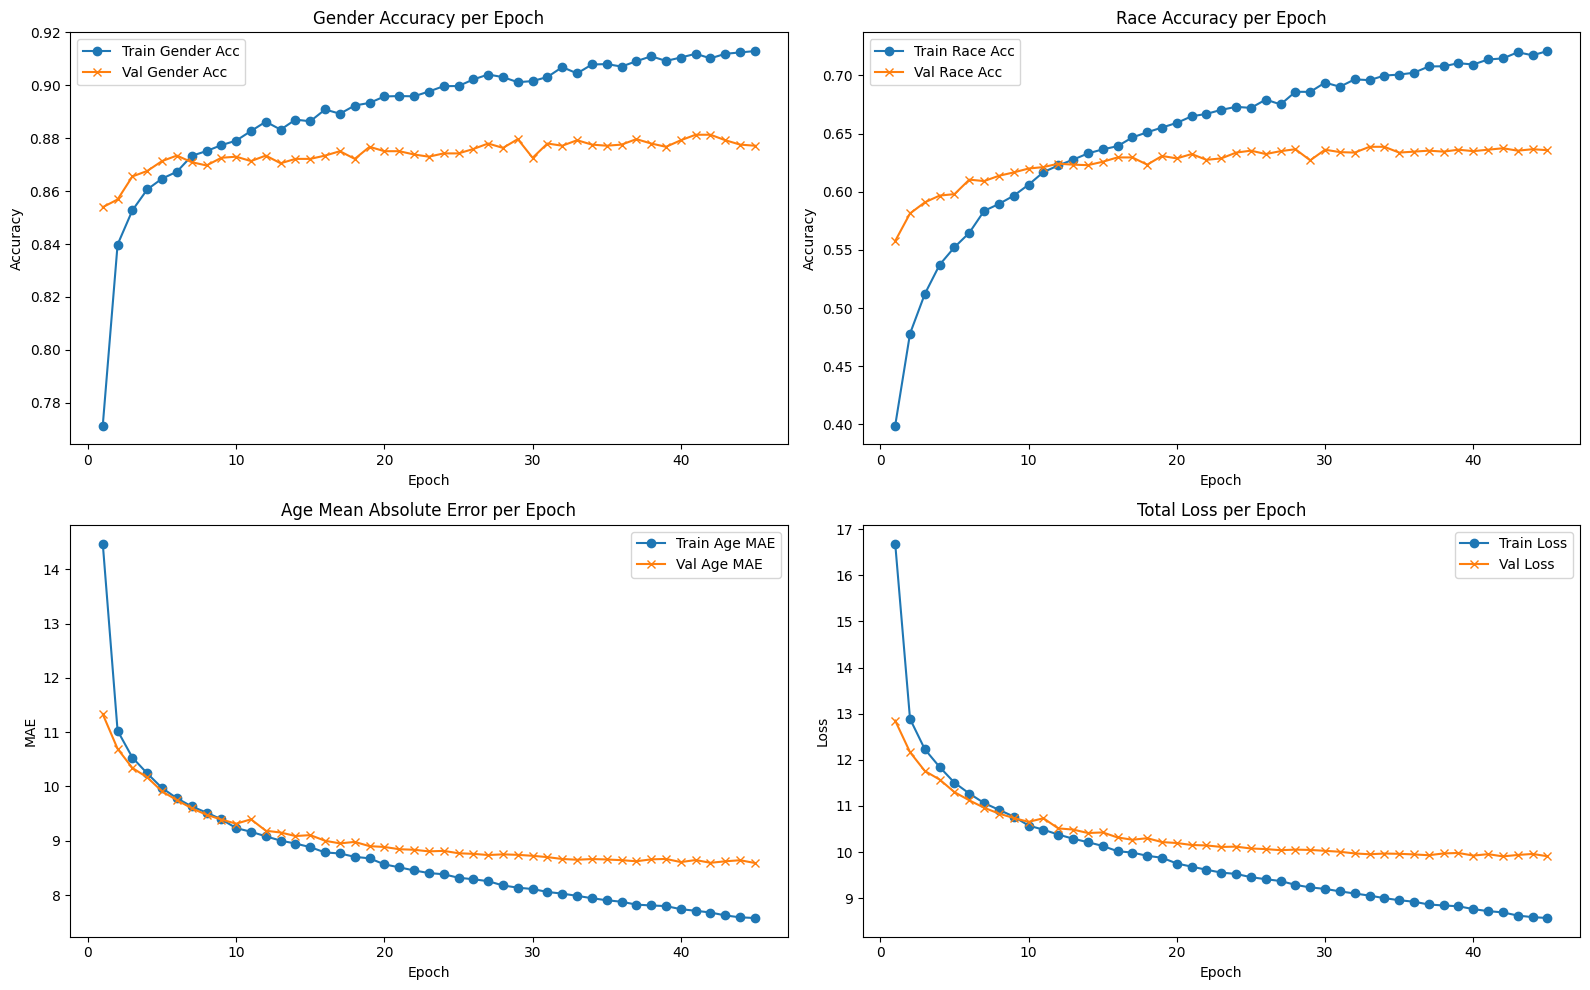

In [10]:
epochs = range(1, len(history.history['loss']) + 1)
plt.figure(figsize=(16, 10))

plt.subplot(2, 2, 1)
plt.plot(epochs, history.history['gender_accuracy'], label='Train Gender Acc', marker='o')
plt.plot(epochs, history.history['val_gender_accuracy'], label='Val Gender Acc', marker='x')
plt.title('Gender Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(epochs, history.history['race_accuracy'], label='Train Race Acc', marker='o')
plt.plot(epochs, history.history['val_race_accuracy'], label='Val Race Acc', marker='x')
plt.title('Race Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(epochs, history.history['age_mae'], label='Train Age MAE', marker='o')
plt.plot(epochs, history.history['val_age_mae'], label='Val Age MAE', marker='x')
plt.title('Age Mean Absolute Error per Epoch')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(epochs, history.history['loss'], label='Train Loss', marker='o')
plt.plot(epochs, history.history['val_loss'], label='Val Loss', marker='x')
plt.title('Total Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

76/76 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step


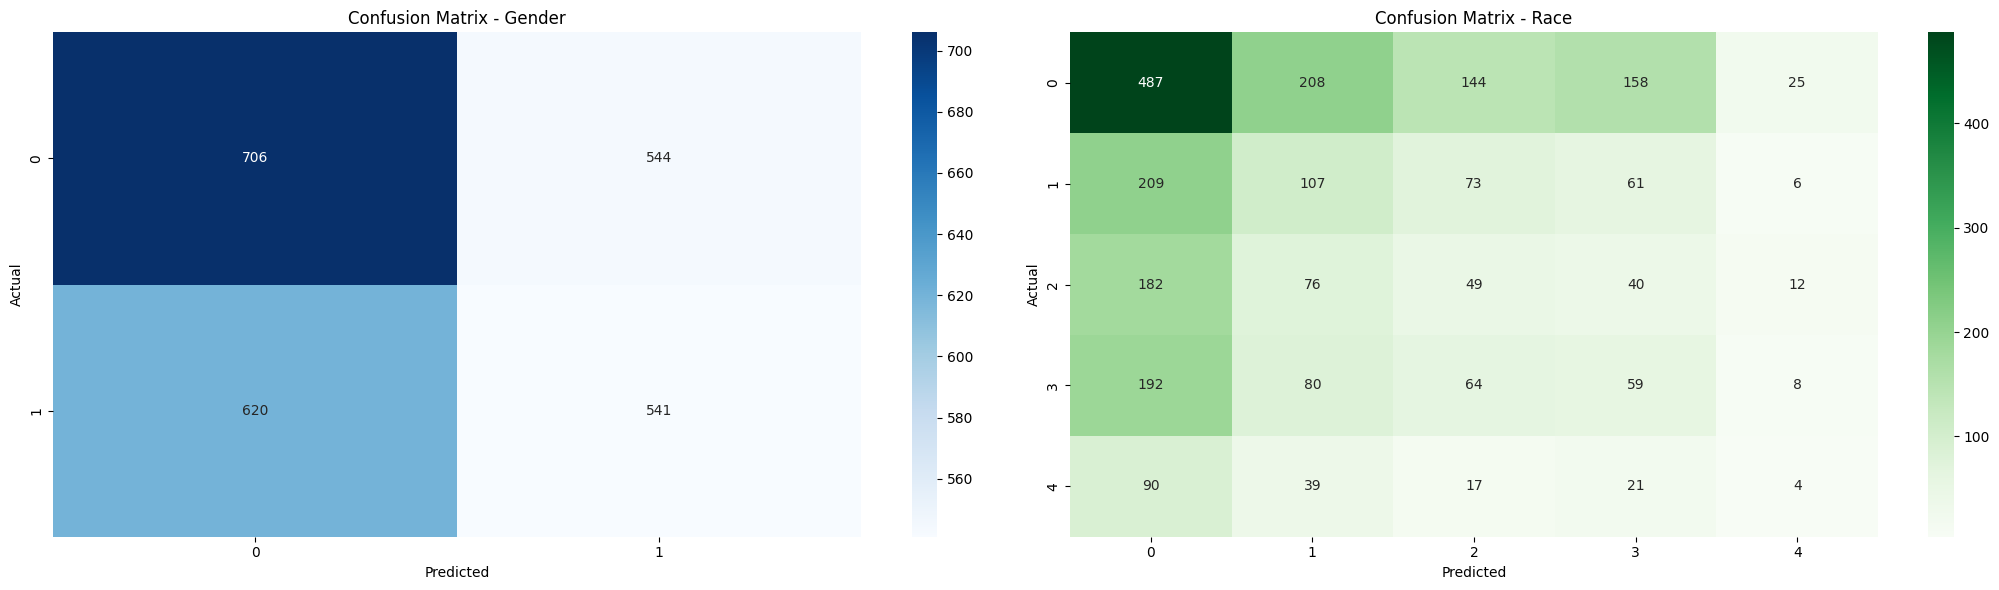

In [64]:
y_pred_gender, y_pred_race, y_pred_age = multi_output_model.predict(test_ds)

y_pred_gender_cls = (y_pred_gender > 0.6).astype(int)
y_pred_race_cls = np.argmax(y_pred_race, axis=1)

y_true_gender = test_df["gender"].values
y_true_race = test_df["race"].values

fig, axes = plt.subplots(1, 2, figsize=(21, 6))
cm_gender = confusion_matrix(y_true_gender, y_pred_gender_cls)
sns.heatmap(cm_gender, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title("Confusion Matrix - Gender")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

cm_race = confusion_matrix(y_true_race, y_pred_race_cls)
sns.heatmap(cm_race, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title("Confusion Matrix - Race")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()

In [24]:
train_df["gender"].value_counts()

gender
0    10074
1     9207
Name: count, dtype: int64

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


/tmp/ipykernel_35/3033854310.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  f"Pred:\nG: {gender_map[int(gender_pred)]}\nA: {age_pred}\nR: {race_map[race_pred]}"


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


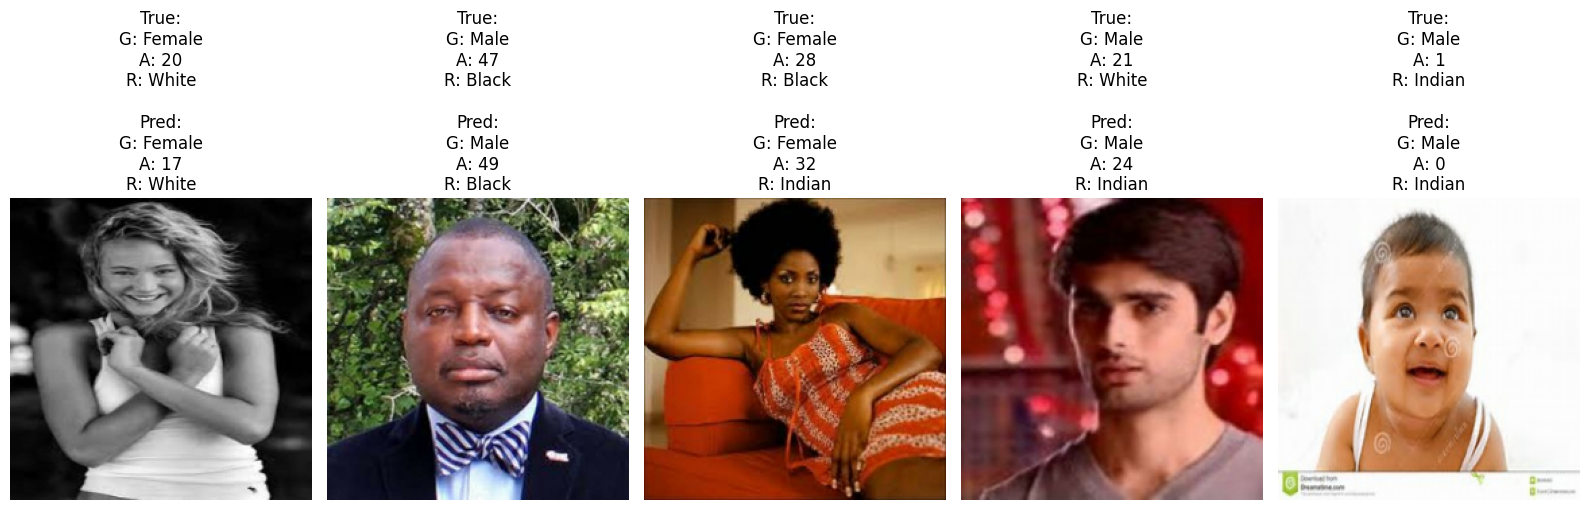

In [79]:
sample_df = test_df.sample(5)

def preprocess_single(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0
    return image

gender_map = {0: "Male", 1: "Female"}
race_map = {0: "White", 1: "Black", 2: "Asian", 3: "Indian", 4: "Others"}

plt.figure(figsize=(16, 8))
for i, row in enumerate(sample_df.itertuples()):
    img_tensor = preprocess_single(row.filepath)
    img_expanded = tf.expand_dims(img_tensor, axis=0)

    pred_gender, pred_race, pred_age = multi_output_model.predict(img_expanded)
    
    gender_pred = (pred_gender > 0.6).astype(int)
    race_pred = np.argmax(pred_race)
    age_pred = int(pred_age[0][0])  # karena regression

    plt.subplot(1, 5, i + 1)
    plt.imshow(img_tensor.numpy())
    plt.axis('off')
    plt.title(
        f"True:\nG: {gender_map[row.gender]}\nA: {row.age}\nR: {race_map[row.race]}\n\n" +
        f"Pred:\nG: {gender_map[int(gender_pred)]}\nA: {age_pred}\nR: {race_map[race_pred]}"
    )

plt.tight_layout()
plt.show()

## Notes: 
I initially intended to explore VGGFace, a transfer learning CNN model pre-trained specifically on facial recognition datasets, to potentially achieve higher accuracy on my task. However, due to environment limitations, I was unable to proceed.

The VGGFace implementation depends on Keras 2.2.4 and TensorFlow 1.14.0, which are no longer supported in current cloud platforms like Google Colab and Kaggle, both of which now use TensorFlow 2.12 or higher by default. Since I rely on these platforms for GPU-based model training, I was unfortunately unable to experiment with VGGFace in its original form.

Official page: https://github.com/rcmalli/keras-vggface/blob/master/README.md

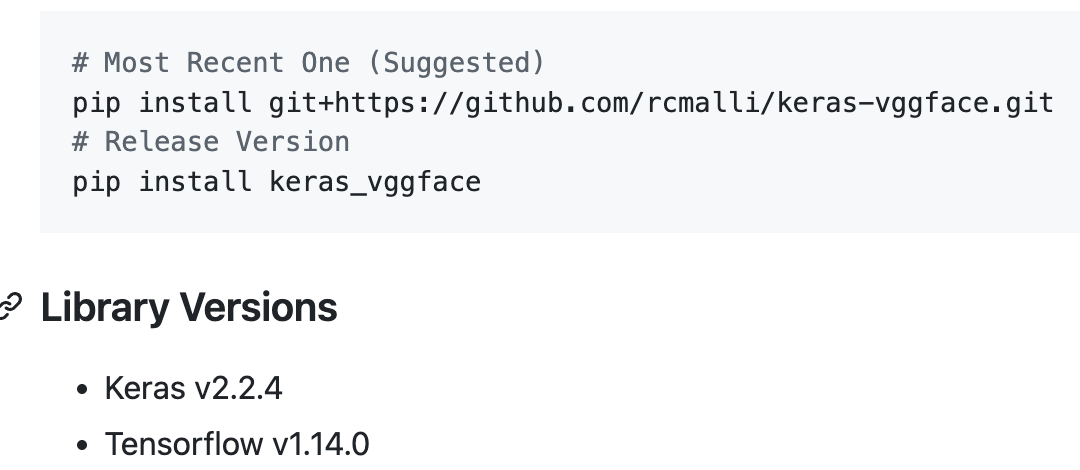
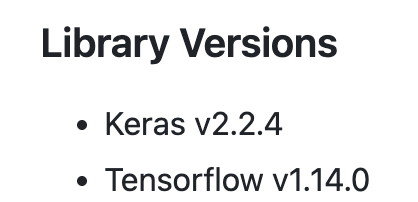

In [ ]:
# Most Recent One (Suggested)
pip install git+https://github.com/rcmalli/keras-vggface.git
# Release Version
pip install keras_vggface

In [45]:
!pip install keras==2.2.4 tensorflow==1.14.0

ERROR: Could not find a version that satisfies the requirement tensorflow==1.14.0 (from versions: 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.0.post1, 2.15.1, 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0)
ERROR: No matching distribution found for tensorflow==1.14.0


In [36]:
import tensorflow as tf
from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input
from keras_vggface import utils
from keras.utils import layer_utils

import numpy as np
from tensorflow.keras import layers, models, Input

IMG_SIZE = 224

# Base model
base = VGGFace(model='vgg16', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base.trainable = False

# Input
input_layer = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base(input_layer, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)

# Output branches
output_gender = layers.Dense(1, activation='sigmoid', name='gender')(x)       # Binary classification
output_race = layers.Dense(5, activation='softmax', name='race')(x)           # 5 classes
output_age = layers.Dense(1, name='age')(x)                                    # Regression

# Build model
multi_output_model2 = models.Model(inputs=input_layer, outputs=[output_gender, output_race, output_age])

# Compile model
multi_output_model2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss={
        'gender': 'binary_crossentropy',
        'race': 'sparse_categorical_crossentropy',
        'age': 'mae'
    },
    metrics={
        'gender': 'accuracy',
        'race': 'accuracy',
        'age': 'mae'
    }
)

multi_output_model2.summary()

ImportError: cannot import name 'layer_utils' from 'keras.utils' (/usr/local/lib/python3.11/dist-packages/keras/api/utils/__init__.py)